<a href="https://colab.research.google.com/github/dean-sh/Movie-Ratings-with-SVD/blob/master/MovieLens_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MovieLens Recommendations - Dean Shabi, Dedi Kovatch, July 2019
=============================================

## Final Project for TCDS - Technion Data Science Specialization

MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.
 
This data set consists of:
	* 100,000 ratings (1-5) from 943 users on 1682 movies. 
	* Each user has rated at least 20 movies. 
        * Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens web site
(movielens.umn.edu) during the seven-month period from September 19th, 
1997 through April 22nd, 1998. This data has been cleaned up - users
who had less than 20 ratings or did not have complete demographic
information were removed from this data set. Detailed descriptions of
the data file can be found at the end of this file.


## Data Description




Here are brief descriptions of the data.

ml-data.tar.gz   -- Compressed tar file.  To rebuild the u data files do this:
                gunzip ml-data.tar.gz
                tar xvf ml-data.tar
                mku.sh

u.data     -- The full u data set, 100000 ratings by 943 users on 1682 items.
              Each user has rated at least 20 movies.  Users and items are
              numbered consecutively from 1.  The data is randomly
              ordered. This is a tab separated list of 
	         user id | item id | rating | timestamp. 
              The time stamps are unix seconds since 1/1/1970 UTC   

u.info     -- The number of users, items, and ratings in the u data set.

u.item     -- Information about the items (movies); this is a tab separated
              list of
              movie id | movie title | release date | video release date |
              IMDb URL | unknown | Action | Adventure | Animation |
              Children's | Comedy | Crime | Documentary | Drama | Fantasy |
              Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
              Thriller | War | Western |
              The last 19 fields are the genres, a 1 indicates the movie
              is of that genre, a 0 indicates it is not; movies can be in
              several genres at once.
              The movie ids are the ones used in the u.data data set.

u.genre    -- A list of the genres.

u.user     -- Demographic information about the users; this is a tab
              separated list of
              user id | age | gender | occupation | zip code
              The user ids are the ones used in the u.data data set.

u.occupation -- A list of the occupations.

u1.base    -- The data sets u1.base and u1.test through u5.base and u5.test
u1.test       are 80%/20% splits of the u data into training and test data.
u2.base       Each of u1, ..., u5 have disjoint test sets; this if for
u2.test       5 fold cross validation (where you repeat your experiment
u3.base       with each training and test set and average the results).
u3.test       These data sets can be generated from u.data by mku.sh.
u4.base
u4.test
u5.base
u5.test

ua.base    -- The data sets ua.base, ua.test, ub.base, and ub.test
ua.test       split the u data into a training set and a test set with
ub.base       exactly 10 ratings per user in the test set.  The sets
ub.test       ua.test and ub.test are disjoint.  These data sets can
              be generated from u.data by mku.sh.

allbut.pl  -- The script that generates training and test sets where
              all but n of a users ratings are in the training data.

mku.sh     -- A shell script to generate all the u data sets from u.data.

## Imports




In [0]:
import numpy as np
import pandas as pd
import collections
import seaborn as sns
%matplotlib inline
# from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
# import tensorflow as tf
# tf.logging.set_verbosity(tf.logging.ERROR)

# # Add some convenience functions to Pandas DataFrame.
# pd.options.display.max_rows = 10
# pd.options.display.float_format = '{:.3f}'.format



# # Install Altair and activate its colab renderer.
# print("Installing Altair...")
# !pip install git+git://github.com/altair-viz/altair.git
# import altair as alt
# alt.data_transformers.enable('default', max_rows=None)
# alt.renderers.enable('colab')
# print("Done installing Altair.")

# # Install spreadsheets and import authentication module.
# USER_RATINGS = False
# !pip install --upgrade -q gspread
# from google.colab import auth
# import gspread
# from oauth2client.client import GoogleCredentials

## **Importing dataset, preprocessing**




In [0]:
# download the MovieLens Data, and create DataFrames containing movies, users, and ratings.

print("Downloading movielens data...")
import zipfile
import urllib.request

urllib.request.urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info'))

In [0]:
# Load each data set (users, movies, and ratings).
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    'ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    'ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# The movies file contains a binary feature for each genre.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"] + genre_cols

movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')


Some Preproccessing

In [0]:
# Since the ids start at 1, we shift them to start at 0.
users["user_id"] = users["user_id"].apply(lambda x: str(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: str(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: str(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

# Compute the number of movies to which a genre is assigned.
genre_occurences = movies[genre_cols].sum().to_dict()

# Since some movies can belong to more than one genre, we create different
# 'genre' columns as follows:
# - all_genres: all the active genres of the movie.
# - genre: randomly sampled from the active genres.
def mark_genres(movies, genres):
    def get_random_genre(gs):
        active = [genre for genre, g in zip(genres, gs) if g==1]
        if len(active) == 0:
            return 'Other'
        return np.random.choice(active)
    def get_all_genres(gs):
        active = [genre for genre, g in zip(genres, gs) if g==1]
        if len(active) == 0:
            return 'Other'
        return '-'.join(active)
    movies['genre'] = [
        get_random_genre(gs) for gs in zip(*[movies[genre] for genre in genres])]
    movies['all_genres'] = [
        get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]

mark_genres(movies, genre_cols)

In [0]:
# Create one merged DataFrame containing all the movielens data.
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')

# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
    """Splits a DataFrame into training and test sets.
    Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
    Returns:
    train: dataframe for training
    test: dataframe for testing
    """
    test = df.sample(frac=holdout_fraction, replace=False)
    train = df[~df.index.isin(test.index)]
    return train, test

In [0]:
movies.head()

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,genre,all_genres
0,0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1995,Comedy,Animation-Children-Comedy
1,1,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1995,Adventure,Action-Adventure-Thriller
2,2,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1995,Thriller,Thriller
3,3,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1995,Comedy,Action-Comedy-Drama
4,4,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1995,Crime,Crime-Drama-Thriller


In [0]:
users.head()

,user_id,age,sex,occupation,zip_code
0,0,24,M,technician,85711
1,1,53,F,other,94043
2,2,23,M,writer,32067
3,3,24,M,technician,43537
4,4,33,F,other,15213


In [0]:
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,195,241,3.0,881250949
1,185,301,3.0,891717742
2,21,376,1.0,878887116
3,243,50,2.0,880606923
4,165,345,1.0,886397596


In [0]:
movielens.head()

,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,genre,all_genres,age,sex,occupation,zip_code
0,195,241,3.0,881250949,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1997,Comedy,Comedy,49,M,writer,55105
1,195,256,2.0,881251577,Men in Black (1997),04-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Men+in+Black+...,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1997,Sci-Fi,Action-Adventure-Comedy-Sci-Fi,49,M,writer,55105
2,195,110,4.0,881251793,"Truth About Cats & Dogs, The (1996)",26-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Truth%20About...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1996,Comedy,Comedy-Romance,49,M,writer,55105
3,195,24,4.0,881251955,"Birdcage, The (1996)",08-Mar-1996,NaN,"http://us.imdb.com/M/title-exact?Birdcage,%20T...",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1996,Comedy,Comedy,49,M,writer,55105
4,195,381,4.0,881251843,"Adventures of Priscilla, Queen of the Desert, ...",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Adventures%20...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1994,Comedy,Comedy-Drama,49,M,writer,55105


# EDA


In [0]:
def configure_plotly_browser_state():
    import IPython
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>'''))

In [0]:
print()

In [0]:
import IPython
IPython.get_ipython().events.register('pre_run_cell', configure_plotly_browser_state)

In [0]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)


data = movielens['rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / movielens.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} Ratings'.format(movielens.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)


In [0]:
# Number of ratings per title
data = df.groupby('title')['rating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 1))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Title (Clipped at 50)',
                   xaxis = dict(title = 'Number of Ratings Per Title'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [0]:
#Identify most popular items

df.groupby('title')['rating'].count().sort_values(ascending = False).head(20)

title
Star Wars (1977)                    583
Contact (1997)                      509
Fargo (1996)                        508
Return of the Jedi (1983)           507
Liar Liar (1997)                    485
English Patient, The (1996)         481
Scream (1996)                       478
Toy Story (1995)                    452
Air Force One (1997)                431
Independence Day (ID4) (1996)       429
Raiders of the Lost Ark (1981)      420
Godfather, The (1972)               413
Pulp Fiction (1994)                 394
Twelve Monkeys (1995)               392
Silence of the Lambs, The (1991)    390
Jerry Maguire (1996)                384
Chasing Amy (1997)                  379
Rock, The (1996)                    378
Empire Strikes Back, The (1980)     367
Star Trek: First Contact (1996)     365
Name: rating, dtype: int64

In [0]:
# Number of ratings per user
data = df.groupby('user_id')['rating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 1))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 50)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [0]:
pd.DataFrame(df.groupby('title')['rating'].mean()).head()

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390


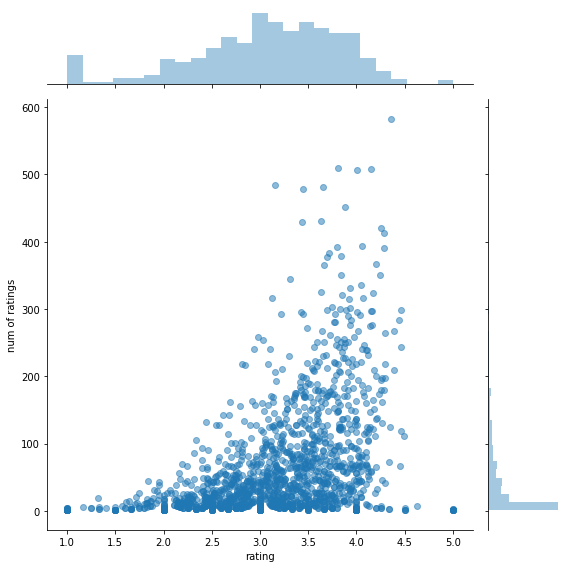

In [0]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
sns.jointplot(x='rating',y='num of ratings',data=ratings,alpha=0.5,height = 8)

In [0]:
users.describe(include=[np.object])

,user_id,sex,occupation,zip_code
count,943,943,943,943
unique,943,2,21,795
top,167,M,student,55414
freq,1,670,196,9


In [0]:
movies.describe(include=[np.object])

,movie_id,title,release_date,imdb_url,year,genre,all_genres
count,1682,1682,1681,1679,1682,1682,1682
unique,1682,1664,240,1660,72,19,216
top,1449,Sliding Doors (1998),01-Jan-1995,http://us.imdb.com/M/title-exact?imdb-title-11...,1996,Drama,Drama
freq,1,2,215,2,355,529,376


In [0]:
pd.concat([users.describe() , movies.describe()], axis=1)

,age,video_release_date,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
count,943.000,0.000,1682.000,1682.000,1682.000,1682.000,1682.000,1682.000,1682.000,1682.000,1682.000,1682.000,1682.000,1682.000,1682.000,1682.000,1682.000,1682.000,1682.000,1682.000,1682.000
mean,34.052,nan,0.001,0.149,0.080,0.025,0.073,0.300,0.065,0.030,0.431,0.013,0.014,0.055,0.033,0.036,0.147,0.060,0.149,0.042,0.016
std,12.193,nan,0.034,0.356,0.272,0.156,0.259,0.458,0.246,0.170,0.495,0.114,0.119,0.227,0.179,0.187,0.354,0.238,0.356,0.201,0.126
min,7.000,nan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,25.000,nan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,31.000,nan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,43.000,nan,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
max,73.000,nan,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [0]:
x = movielens18.groupby('i_id').count().sort_values(by = 'rating' , ascending = False)['rating']
x = pd.DataFrame(x)
x.columns = ['number of ratings']
x = x.merge(movies_df, how = 'left', on = 'i_id')

y = movielens18.groupby('i_id').mean().sort_values(by = 'rating' , ascending = False)['rating']
y = pd.DataFrame(y)
y.columns = ['Avg rating']
x = x.merge(y, how = 'left', on = 'i_id')

xx = x.sort_values(by = 'number of ratings', ascending = False)
hist_data = xx[xx['number of ratings']>20]
hist_data.head(10)

,i_id,number of ratings,title,genres,Avg rating
0,296,67310,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.174231
1,356,66172,Forrest Gump (1994),Comedy|Drama|Romance|War,4.029000
2,318,63366,"Shawshank Redemption, The (1994)",Crime|Drama,4.446990
3,593,63299,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,4.177057
4,480,59715,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,3.664741
5,260,54502,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.190672
6,110,53769,Braveheart (1995),Action|Drama|War,4.042534
7,589,52244,Terminator 2: Judgment Day (1991),Action|Sci-Fi,3.931954
8,2571,51334,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.187186
9,527,50054,Schindler's List (1993),Drama|War,4.310175


In [0]:
x = movielens18.groupby('u_id').count().sort_values(by = 'rating' , ascending = False)['rating']
x = pd.DataFrame(x)
x.columns = ['number of ratings']
# x = x.merge(movies_df, how = 'left', on = 'u_id')

y = movielens18.groupby('u_id').mean().sort_values(by = 'rating' , ascending = False)['rating']
y = pd.DataFrame(y)
y.columns = ['Avg rating']
x = x.merge(y, how = 'left', on = 'u_id')

xx = x.sort_values(by = 'number of ratings', ascending = False)
hist_data = xx[xx['number of ratings']>20]
hist_data.head(10)

,number of ratings,Avg rating
u_id,,
118205,9254,3.279069
8405,7515,3.208317
82418,5646,3.516915
121535,5520,2.793116
125794,5491,3.762976
74142,5447,1.577474
34576,5356,3.011669
131904,5330,3.248874
83090,5169,2.404914


(array([    0.,  5000., 10000., 15000., 20000., 25000., 30000., 35000.,
        40000., 45000.]), <a list of 10 Text yticklabel objects>)

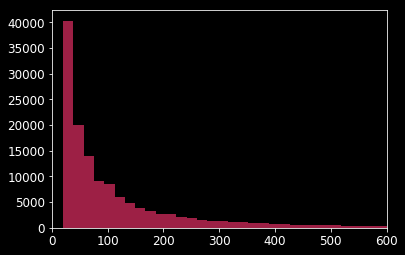

In [0]:

plt.style.use('dark_background')

x[['number of ratings']].hist(column = 'number of ratings',bins = 500, figsize=(6,4), color = '#9d2045')
# plt.title('Distribution of Ratings per User',size = 30)
plt.title(None)
plt.grid(b=None)
plt.xlim(0,600)
plt.xticks(size = 12)
plt.yticks(size = 12)
# plt.xlabel('Users', size = 20)
# plt.ylabel('Number of Ratings', size = 20)

# Content-Based Filtering
Content-based filtering uses item features to recommend other items similar to what the user likes, based on their previous actions or explicit feedback.


Content-based filtering uses item features to recommend other items similar to what the user likes, based on their previous actions or explicit feedback.


<img src="https://developers.google.com/machine-learning/recommendation/images/Matrix1.svg" width="80%">
---

**Content-based Filtering Advantages & Disadvantages**

**Advantages**


1.   The model doesn't need any data about other users, since the recommendations are specific to this user. This makes it easier to scale to a large number of users.
2.  The model can capture the specific interests of a user, and can recommend niche items that very few other users are interested in.


**Disadvantages**


1.   Since the feature representation of the items are hand-engineered to some extent, this technique requires a lot of domain knowledge. Therefore, the model can only be as good as the hand-engineered features.

2.  The model can only make recommendations based on existing interests of the user. In other words, the model has limited ability to expand on the users' existing interests.





In [0]:
#Using TF-IDF for getting a corpus vector of movie names.
# After that, using a simmilarity metric between those vectors, to find the most simmilar movies.

movielens.all_genres.value_counts()

Drama                        13257
Comedy                        9828
Comedy-Romance                5055
Drama-Romance                 4767
Action-Thriller               3550
                             ...  
Action-Comedy-Crime-Drama        5
Action-Adventure-Children        5
Crime-Film-Noir                  4
Comedy-Documentary               1
Fantasy                          1
Name: all_genres, Length: 216, dtype: int64

In [0]:
movielens.all_genres.head()

0                            Comedy
1    Action-Adventure-Comedy-Sci-Fi
2                    Comedy-Romance
3                            Comedy
4                      Comedy-Drama
Name: all_genres, dtype: object

**Using TF-IDF on the genre, movie title**

In [0]:
# Break up the big genre string into a string array
content_based = movielens.copy()
content_based['all_genres'] = content_based['all_genres'].str.split('-')
# Convert genres to string value
content_based['all_genres'] = content_based['all_genres'].fillna("").astype('str')
content_based['all_genres'].value_counts()

['Drama']                                 13257
['Comedy']                                 9828
['Comedy', 'Romance']                      5055
['Drama', 'Romance']                       4767
['Action', 'Thriller']                     3550
                                          ...  
['Action', 'Comedy', 'Crime', 'Drama']        5
['Comedy', 'Crime', 'Drama']                  5
['Crime', 'Film', 'Noir']                     4
['Comedy', 'Documentary']                     1
['Fantasy']                                   1
Name: all_genres, Length: 216, dtype: int64

**first test: creating a tf-idf from the genre alone** - EATS ALL THE RAM

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 1),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(content_based['genre'])
tfidf_matrix.shape

(100000, 21)

In [0]:
import sklearn.preprocessing as pp

def cosine_similarities(mat):
    col_normed_mat = pp.normalize(mat.tocsc(), axis=0)
    return col_normed_mat.T * col_normed_mat

In [0]:
cosine_similarities(tfidf_matrix.T)

In [0]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel

# Change chunk_size to control resource consumption and speed
# Higher chunk_size means more memory/RAM needed but also faster 
chunk_size = 1500 
matrix_len = tfidf_matrix.shape[0] # Not sparse numpy.ndarray

def similarity_cosine_by_chunk(start, end):
    if end > matrix_len:
        end = matrix_len
    return linear_kernel(X=tfidf_matrix[start:end], Y=tfidf_matrix) # scikit-learn function

for chunk_start in range(0, matrix_len, chunk_size):
    cosine_similarity_chunk = similarity_cosine_by_chunk(chunk_start, chunk_start+chunk_size)
    # Handle cosine_similarity_chunk  ( Write it to file_timestamp and close the file )
    # Do not open the same file again or you may end up with out of memory after few chunks 



In [0]:
#cosine simmilarity, which is the same as dot-product in this case
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)


In [0]:
cosine_sim.shape

# Recommandation via Correlation analysis

A simple correlation analysis recommender



In [0]:
#We want to check which movies correlate with 'Star Wars' movie

moviemat = df.pivot_table(index='user_id',columns='title',values='rating')
starwars_user_ratings = moviemat['Star Wars (1977)']
similar_to_starwars = moviemat.corrwith(starwars_user_ratings)
corr_starwars = pd.DataFrame(similar_to_starwars,columns=['Correlation'])
corr_starwars.dropna(inplace=True)
corr_starwars.sort_values('Correlation', ascending=False).head(20)

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2522: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2451: RuntimeWarning:

divide by zero encountered in true_divide



,Correlation
title,
Commandments (1997),1.0
Cosi (1996),1.0
No Escape (1994),1.0
Stripes (1981),1.0
Man of the Year (1995),1.0
Hollow Reed (1996),1.0
"Beans of Egypt, Maine, The (1994)",1.0
"Good Man in Africa, A (1994)",1.0
"Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)",1.0


In [0]:
# Some resualts do not make sense due to low number of ratings.

ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
corr_starwars = corr_starwars.join(ratings['num of ratings'])
corr_starwars[corr_starwars['num of ratings']>100].sort_values('Correlation',ascending=False).head(10)

,Correlation,num of ratings
title,,
Star Wars (1977),1.000000,583
"Empire Strikes Back, The (1980)",0.747981,367
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130
"Sting, The (1973)",0.367538,241
Indiana Jones and the Last Crusade (1989),0.350107,331
Pinocchio (1940),0.347868,101
"Frighteners, The (1996)",0.332729,115


# Collaborating Filltering with Surprise library

In [0]:
!pip install scikit-surprise

from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

     |████████████████████████████████| 3.3MB 2.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/ec/c0/55/3a28eab06b53c220015063ebbdb81213cd3dcbb72c088251ec
Successfully built scikit-surprise


In [0]:
min_item_clicks = 50
filter_items = movielens['movie_id'].value_counts() > min_item_clicks
filter_items = filter_items[filter_items].index.tolist()

min_user_clicks = 50
filter_users = movielens['user_id'].value_counts() > min_user_clicks
filter_users = filter_users[filter_users].index.tolist()

df_filtered = movielens[(movielens['movie_id'].isin(filter_items)) & (movielens['user_id'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(movielens.shape))
print('The new data frame shape:\t{}'.format(df_filtered.shape))

The original data frame shape:	(100000, 34)
The new data frame shape:	(72829, 34)


In [0]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_filtered[['user_id', 'movie_id', 'rating']], reader)

In [0]:
benchmark = []

# Iterate over all algorithms
for algo in [SVD(), SVDpp(),SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:

    # Perform cross validation
    print('statring cv for {}'.format(algo))
    results = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)
    
    # Get results & appensurprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')d algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algo).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
    

In [0]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.911311,161.063439,2.572903
KNNBaseline,0.920567,0.449645,3.724718
SVD,0.926022,4.540039,0.141301
SlopeOne,0.934167,0.501804,2.111923
BaselineOnly,0.935144,0.117489,0.133268
KNNWithMeans,0.937647,0.363125,3.235781
KNNWithZScore,0.938816,0.412725,3.479334
CoClustering,0.945486,1.077938,0.169708
NMF,0.951034,4.721857,0.149676


In [0]:
#HyperParameterTunning for BaseLineOnly

benchmark = []

methods = 'als'
n_epochs = [10,15,20,40]
reg_us = [2, 5 ,10]
reg_is = [2, 5, 10]

for n_epoch in n_epochs:
  for reg_u in reg_us:
    for reg_i in reg_is:
      bsl_options = {'method': 'als',
                     'n_epochs': n_epoch,
                     'reg_u': reg_u,
                     'reg_i': reg_i}

      algo = BaselineOnly(bsl_options=bsl_options)
      results = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)

      tmp = pd.DataFrame.from_dict(results).mean(axis=0)
      tmp = tmp.append(pd.Series([str(algo).split(' ')[0].split('.')[-1]], index=['Algorithm']))
      tmp['n_epochs'] = n_epoch
      tmp['reg_u'] = reg_u
      tmp['reg_i'] = reg_i
      benchmark.append(tmp)


In [0]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,fit_time,test_time,n_epochs,reg_u,reg_i
Algorithm,,,,,,
BaselineOnly,0.918615,0.265777,0.110717,40,2,2
BaselineOnly,0.918651,0.091991,0.126337,10,10,2
BaselineOnly,0.918732,0.264995,0.131282,40,2,5
BaselineOnly,0.918965,0.145354,0.127485,20,10,2
BaselineOnly,0.919010,0.146003,0.110739,20,10,5
BaselineOnly,0.919020,0.272649,0.113949,40,2,10
BaselineOnly,0.919061,0.086128,0.119886,10,2,5
BaselineOnly,0.919105,0.088744,0.133683,10,5,2
BaselineOnly,0.919206,0.090425,0.129215,10,5,5


In [0]:
trainset, testset = train_test_split(data, test_size=0.25)
bsl_options = {'method': 'als',
               'n_epochs': 40,
               'reg_u': 2,
               'reg_i': 2}

algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 0.9256


0.9255923566007465

In [0]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)


In [0]:
df_ToMerge =  movies


df_ToMerge =  movielens[['user_id', 'movie_id', 'rating', 'title',
       'genre_unknown','Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'year',
       'genre', 'all_genres', 'age', 'sex', 'occupation']]

df_ToMerge.rename(columns={'movie_id': 'iid'}, inplace=True)
df = df.merge(df_ToMerge, on='iid', how='left' )

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [0]:
df.head(2)

,uid,iid,rui,est,details,Iu,Ui,err,user_id,rating,title,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,genre,all_genres,age,sex,occupation
0,718,356,4.0,3.818739,{'was_impossible': False},47,172,0.181261,153,4.0,One Flew Over the Cuckoo's Nest (1975),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1975,Drama,Drama,25,M,student
1,718,356,4.0,3.818739,{'was_impossible': False},47,172,0.181261,295,5.0,One Flew Over the Cuckoo's Nest (1975),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1975,Drama,Drama,43,F,administrator


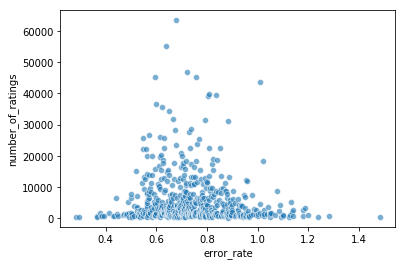

In [0]:
temp1 = df.loc[:,('title', 'err')].groupby('title').mean().sort_values(by = 'err')
temp2 = df['title'].value_counts()
temp3 = temp1.join(temp2, on = 'title',  how='left', lsuffix='_caller')
temp3.rename(columns={'err': 'error_rate', 'title': 'number_of_ratings'}, inplace=True)

sns.scatterplot(data = temp3, x ='error_rate' , y = 'number_of_ratings', alpha= 0.6)

In [0]:
temp1 = movies.loc[:, ('title', 'Action', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western')]

temp4 = temp3.merge(temp1, on = 'title',  how='left')


In [0]:
df.corr().sort_values(by = 'err').loc[:,'err']

rui                  -0.246602
est                  -0.104338
Ui                   -0.026051
Thriller             -0.024476
Iu                   -0.016871
Drama                -0.013710
Film-Noir            -0.011290
Western              -0.008030
Action               -0.007207
Mystery              -0.006424
War                  -0.006029
Fantasy              -0.001258
Adventure            -0.000309
Crime                 0.000189
Animation             0.000416
Romance               0.003093
Children              0.004586
Sci-Fi                0.010299
Comedy                0.016062
iid_caller            0.016162
Documentary           0.018597
Musical               0.019215
Horror                0.019351
err                   1.000000
video_release_date         NaN
genre_unknown              NaN
Name: err, dtype: float64

In [0]:
# best_predictions
df.sort_values(by='err')[-10:]

,uid,iid,rui,est,details,Iu,Ui,err,user_id,rating,title,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,genre,all_genres,age,sex,occupation
2410918,313,172,1.0,4.886816,{'was_impossible': False},123,220,3.886816,415,5.0,"Princess Bride, The (1987)",0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1987,Comedy,Action-Adventure-Comedy-Romance,20,F,student
2410917,313,172,1.0,4.886816,{'was_impossible': False},123,220,3.886816,536,4.0,"Princess Bride, The (1987)",0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1987,Comedy,Action-Adventure-Comedy-Romance,36,M,engineer
2410916,313,172,1.0,4.886816,{'was_impossible': False},123,220,3.886816,201,2.0,"Princess Bride, The (1987)",0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1987,Comedy,Action-Adventure-Comedy-Romance,41,F,educator
2410915,313,172,1.0,4.886816,{'was_impossible': False},123,220,3.886816,496,5.0,"Princess Bride, The (1987)",0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1987,Comedy,Action-Adventure-Comedy-Romance,20,M,student
2410914,313,172,1.0,4.886816,{'was_impossible': False},123,220,3.886816,416,5.0,"Princess Bride, The (1987)",0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1987,Comedy,Action-Adventure-Comedy-Romance,27,F,other
2410913,313,172,1.0,4.886816,{'was_impossible': False},123,220,3.886816,143,5.0,"Princess Bride, The (1987)",0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1987,Comedy,Action-Adventure-Comedy-Romance,53,M,programmer
2411132,313,172,1.0,4.886816,{'was_impossible': False},123,220,3.886816,339,5.0,"Princess Bride, The (1987)",0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1987,Comedy,Action-Adventure-Comedy-Romance,46,M,engineer
2411133,313,172,1.0,4.886816,{'was_impossible': False},123,220,3.886816,127,5.0,"Princess Bride, The (1987)",0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1987,Comedy,Action-Adventure-Comedy-Romance,24,F,marketing
2411155,313,172,1.0,4.886816,{'was_impossible': False},123,220,3.886816,806,3.0,"Princess Bride, The (1987)",0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1987,Comedy,Action-Adventure-Comedy-Romance,41,F,healthcare
2410908,313,172,1.0,4.886816,{'was_impossible': False},123,220,3.886816,353,3.0,"Princess Bride, The (1987)",0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1987,Comedy,Action-Adventure-Comedy-Romance,29,F,librarian


In [0]:
#worst_predictions
df.sort_values(by='err')[:10]

,uid,iid,rui,est,details,Iu,Ui,err
6976,238,189,1.0,4.457731,{'was_impossible': False},118,94,3.457731
10984,278,63,1.0,4.462070,{'was_impossible': False},266,211,3.462070
7708,704,190,1.0,4.483769,{'was_impossible': False},81,199,3.483769
18447,776,99,1.0,4.535799,{'was_impossible': False},29,380,3.535799
15271,433,8,1.0,4.603552,{'was_impossible': False},31,216,3.603552
3243,587,97,1.0,4.608203,{'was_impossible': False},155,293,3.608203
20290,619,99,1.0,4.617288,{'was_impossible': False},73,380,3.617288
6130,711,135,1.0,4.653913,{'was_impossible': False},107,81,3.653913
10157,404,574,5.0,1.254117,{'was_impossible': False},364,37,3.745883
17096,238,317,1.0,4.774659,{'was_impossible': False},118,223,3.774659


AttributeError: ignored

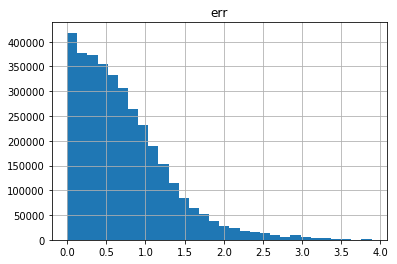

In [0]:
df.hist('err', bins = 30)



In [0]:
# next steps:
# merge with movie title
# try to understand most predictive movies
# try to understand number on rating per movie as a threshhold
# bulid mini recommandation system



**Dean:**  That looks great! 

I think we should "bucket" the errors accourding to 
the number of ratings, or the number of users.

similar code I've done in another project (my home-test for a job)
(RUL is the target label)

## Bucketing the errors accourding to RUL range
- The idea is that errors tend to decrease as RUL goes down, since the model can predict it more accurately.
- I've used the best NN model to show the results.

In [0]:
b = 25
buckets = np.linspace(y_test1b.min(), y_test1b.max(),num = b)
errors = np.zeros(b)
count = np.zeros(b)
buckets

array([  7.   ,  10.875,  14.75 ,  18.625,  22.5  ,  26.375,  30.25 ,
        34.125,  38.   ,  41.875,  45.75 ,  49.625,  53.5  ,  57.375,
        61.25 ,  65.125,  69.   ,  72.875,  76.75 ,  80.625,  84.5  ,
        88.375,  92.25 ,  96.125, 100.   ])

In [0]:
y_baseline_nn = baseline_nn.predict(X_test1b)
y_baseline_nn = np.ravel(y_baseline_nn)

for i, pred in enumerate(y_baseline_nn):
    se = (y_test1b[i] - pred) ** 2
    for j, rng in enumerate(buckets):
        if y_test1b[i]<=rng:
            errors[j] = errors[j] + se
            count[j] = count[j] + 1
            
    
buckMSE = np.sqrt(errors/count)
buckMSE

array([ 1.42357063,  4.01417318,  5.26842845,  7.2672052 , 11.47170205,
       15.1112672 , 17.9106525 , 19.97499134, 21.63347358, 22.42848769,
       23.08972722, 23.32993331, 23.42661824, 23.24184066, 22.95831088,
       22.63193758, 22.23733372, 21.91195211, 21.40900731, 20.8711825 ,
       20.26332965, 19.70385302, 19.15706969, 18.66028937, 10.52822712])

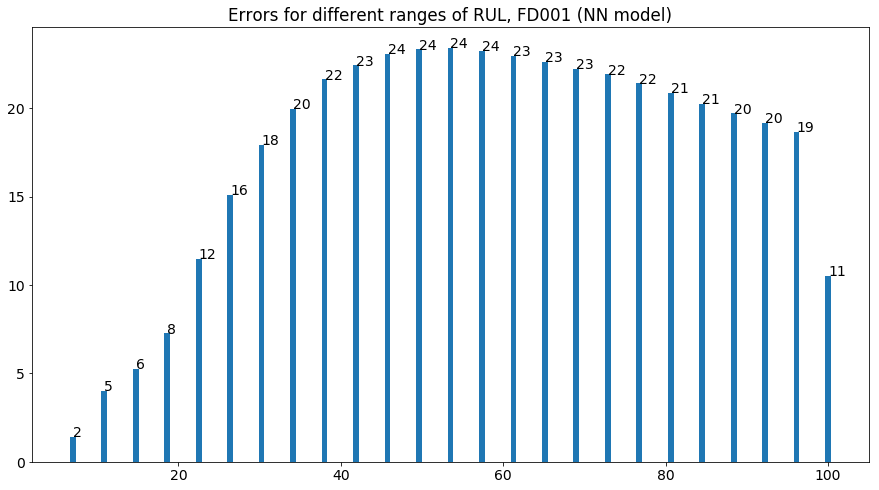

In [0]:
plt.figure(figsize = (15,8));
plt.bar(buckets, buckMSE, width=0.7)
plt.title("Errors for different ranges of RUL, FD001 (NN model)")
# plt.xticks(buckets);
for i, txt in enumerate(buckMSE):
    plt.annotate(math.ceil(txt), (buckets[i], buckMSE[i]))


# Collaborative Filtering - Sparse MF algorithm (Andrew Ng)
implemented by us from the Coursera Course

## Algorithm (sparse MF):

In [0]:
pivot = movielens.pivot_table(values = 'rating', index = 'movie_id', columns = 'user_id')
pivot.fillna(0, inplace = True)

In [0]:
def cofiCostFunc(params, Y, R, num_users, num_movies,
                      num_features, lambda_=0.0):
    """
    Collaborative filtering cost function.
    
    Parameters
    ----------
    params : array_like
        The parameters which will be optimized. This is a one
        dimensional vector of shape (num_movies x num_users, 1). It is the 
        concatenation of the feature vectors X and parameters Theta.
    
    Y : array_like
        A matrix of shape (num_movies x num_users) of user ratings of movies.
    
    R : array_like
        A (num_movies x num_users) matrix, where R[i, j] = 1 if the 
        i-th movie was rated by the j-th user.
    
    num_users : int
        Total number of users.
    
    num_movies : int
        Total number of movies.
    
    num_features : int
        Number of features to learn.
    
    lambda_ : float, optional
        The regularization coefficient.
    
    Returns
    -------
    J : float
        The value of the cost function at the given params.
    
    grad : array_like
        The gradient vector of the cost function at the given params.
        grad has a shape (num_movies x num_users, 1)
    
    Instructions
    ------------
    Compute the cost function and gradient for collaborative filtering.
    Concretely, you should first implement the cost function (without
    regularization) and make sure it is matches our costs. After that,
    you should implement thegradient and use the checkCostFunction routine 
    to check that the gradient is correct. Finally, you should implement
    regularization.
    
    Notes
    -----
    - The input params will be unraveled into the two matrices:
        X : (num_movies  x num_features) matrix of movie features >>>   X (m * p)
        Theta : (num_users  x num_features) matrix of user features >>> Theta (n * p)

    - You should set the following variables correctly:

        X_grad : (num_movies x num_features) matrix, containing the 
                 partial derivatives w.r.t. to each element of X
        Theta_grad : (num_users x num_features) matrix, containing the 
                     partial derivatives w.r.t. to each element of Theta

    - The returned gradient will be the concatenation of the raveled 
      gradients X_grad and Theta_grad.
    """
    # Unfold the X and Theta matrices from params
    X = params[:num_movies*num_features].reshape(num_movies, num_features) # (m * p)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features) # (n * p)

    # You need to return the following values correctly
    J = 0
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)

    # ====================== YOUR CODE HERE ======================

    M = np.dot(X, Theta.T)
    Z = np.square(np.multiply(R , M) - Y) # (m * n) 
    J = 0.5 * np.sum(Z)
    
    Z2 = np.multiply(R , M) - Y #(m * n) 

    X_grad = np.dot(Z2,Theta) + lambda_* X  # (m*n)dot(n*p)
    Theta_grad = np.dot(Z2.T,X) + lambda_* Theta # (m*n)dot(m*p)
        
    J +=  0.5*lambda_*(np.sum(np.square(X))+np.sum(np.square(Theta)))
    # =============================================================
    
    grad = np.concatenate([X_grad.ravel(), Theta_grad.ravel()])
    return J, grad

In [0]:
def normalizeRatings(Y, R):
    """
    Preprocess data by subtracting mean rating for every movie (every row).

    Parameters
    ----------
    Y : array_like
        The user ratings for all movies. A matrix of shape (num_movies x num_users).

    R : array_like
        Indicator matrix for movies rated by users. A matrix of shape (num_movies x num_users).

    Returns
    -------
    Ynorm : array_like
        A matrix of same shape as Y, after mean normalization.

    Ymean : array_like
        A vector of shape (num_movies, ) containing the mean rating for each movie.
    """
    m, n = Y.shape
    Ymean = np.zeros(m)
    Ynorm = np.zeros(Y.shape)

    for i in range(m):
        idx = R[i, :] == 1
        Ymean[i] = np.mean(Y[i, idx])
        Ynorm[i, idx] = Y[i, idx] - Ymean[i]

    return Ynorm, Ymean


In [0]:
#  Useful Values
num_movies, num_users = pivot.shape
num_features = 10


In [0]:
#  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies by 
#  943 users

Y = pivot.values

#  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a
#  rating to movie i

idx = np.where(pivot>0)

R = np.zeros_like(Y)

R[idx] = 1

#  X : (num_movies  x num_features) matrix of movie features >>>   X = (1682 X p)
#  Theta : (num_users  x num_features) matrix of user features >>> Theta = (943 X p)

# Set Initial Parameters (Theta, X)
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

initial_parameters = np.concatenate([X.ravel(), Theta.ravel()])


**Next - try to optimize the training parameters, and use test-train split**

In [0]:
from scipy import optimize

def trainRecommender(Y, R, X, Theta, n_users = 943):
    
    Ynorm, Ymean = normalizeRatings(Y, R)

    # Set options for scipy.optimize.minimize
    options = {'maxiter': 100}

    # Set Regularization
    lambda_ = 10
    res = optimize.minimize(lambda x: cofiCostFunc(x, Ynorm, R, num_users,
                                                   num_movies, num_features, lambda_),
                            initial_parameters,
                            method='TNC',
                            jac=True,
                            options=options)
    theta = res.x

    # Unfold the returned theta back into U and W
    X = theta[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = theta[num_movies*num_features:].reshape(num_users, num_features)

    print('Recommender system learning completed.')
    
    return (X, Theta, Ynorm, Ymean)
    
X, Theta, Ynorm, Ymean = trainRecommender(Y, R, X, Theta)

Recommender system learning completed.


In [0]:
#Predictions:
p = np.dot(X, Theta.T)

#Adding back the mean of every movie, Ymean
predictions = p +  Ymean[:,np.newaxis]  #<< broadcasting, adding the Ymean vector to each column of p

pd.DataFrame(predictions).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609
0,5.020299,3.313386,4.323094,3.987173,3.913902,4.074329,4.517856,4.133638,4.253894,4.281907,4.364387,3.790754,4.196639,3.899172,3.191059,3.264718,3.714995,3.620100,4.297834,3.839726,3.975566,3.887991,4.279534,4.280526,3.823305,3.844617,4.873452,3.843786,4.160640,4.066453,3.867474,3.436198,4.053843,4.153207,4.064059,3.671564,3.581617,3.191378,3.474342,3.978907,...,3.582514,4.186750,3.935984,4.488017,3.850634,2.927744,4.339079,4.040313,4.232621,3.917539,4.076006,3.713674,4.335136,3.731457,2.550273,3.750893,3.695468,4.210062,3.958515,4.444233,3.695653,3.083785,3.412366,4.063433,3.821545,4.071047,4.051008,4.202909,1.386896,4.019180,4.169439,3.026164,4.035158,4.795028,3.449409,4.733999,4.365159,4.337135,4.218139,4.318423
1,3.929422,3.570193,3.864681,3.457279,3.409461,3.586891,3.348663,3.896000,3.685751,3.690572,3.678891,3.326754,3.761402,3.426266,3.453264,3.608644,3.729219,3.381391,3.924233,3.640739,3.472207,3.483611,4.048776,3.731203,3.460987,3.341881,4.149577,3.549399,3.523410,3.625951,3.476551,3.360178,3.526379,3.693882,3.609268,3.487034,3.191409,2.932076,3.318379,3.543332,...,3.070904,3.433349,3.467022,3.822643,3.466651,4.640702,3.801923,3.215736,3.649092,3.599479,3.602419,3.739929,3.605222,3.274921,3.015177,3.565423,3.346617,3.701964,3.392044,3.969816,3.348265,3.595728,3.089313,3.435075,3.476122,3.671883,3.556223,3.637356,3.220989,3.626374,3.670833,3.865828,3.567350,3.964931,3.487165,3.852500,3.580475,3.704033,3.578813,3.666632
2,3.129026,2.748832,2.961807,2.773018,2.764006,2.938637,2.847023,2.966059,2.864563,2.898272,2.896631,2.699789,2.901646,2.747663,2.566298,2.739485,2.798066,2.738720,2.928080,2.797058,2.766440,2.762380,3.052874,2.960913,2.753587,2.730580,3.040122,2.805719,2.827383,2.936110,2.782597,2.667856,2.820506,2.932041,2.845586,2.814535,2.674119,2.478634,2.656071,2.823974,...,2.664983,2.800837,2.800231,2.916679,2.807003,2.917747,2.916869,2.713406,2.865038,2.860016,2.855670,2.844832,2.872473,2.721855,2.424050,2.807479,2.733116,2.873219,2.761861,3.010993,2.626121,2.787791,2.755545,2.826865,2.794629,2.847007,2.809259,2.839752,2.503528,2.791656,2.840342,2.575664,2.838985,3.115571,2.669794,2.980200,2.853196,2.909783,2.814738,2.982867
3,4.005954,4.009078,3.998279,3.991040,3.999149,3.990523,4.007358,4.007518,3.989548,4.002851,3.989087,3.997217,4.003385,3.995898,4.022425,3.996959,3.985582,4.012204,3.995895,4.008483,4.000195,3.998040,4.001890,3.999772,3.999738,4.001928,3.967038,4.002000,3.998002,4.005492,4.003351,4.000836,3.995973,4.007240,3.994642,4.004184,4.006378,4.010652,4.007136,3.999445,...,4.012717,3.984865,4.001607,3.999254,4.006769,4.033914,3.992156,3.995964,3.997244,4.008534,3.996561,3.993933,3.986538,4.015819,4.025114,4.004547,4.009825,3.997177,4.002261,3.996791,3.993860,4.020742,4.001898,4.002685,4.002015,3.996829,3.996510,3.988397,4.048733,3.996604,3.994150,4.005272,4.001429,4.007324,4.001981,3.990539,3.992849,4.004177,3.988785,4.008005
4,3.509151,3.465003,3.472661,3.497621,3.506482,3.495056,3.491949,3.491623,3.498979,3.486082,3.501954,3.508762,3.475645,3.502875,3.445989,3.544567,3.487336,3.500125,3.493137,3.485605,3.495462,3.503346,3.486078,3.486685,3.505865,3.504402,3.514747,3.501210,3.503119,3.459687,3.493641,3.502479,3.500501,3.493892,3.506011,3.507898,3.501356,3.501843,3.508596,3.496355,...,3.519669,3.507170,3.504657,3.496941,3.501634,3.442125,3.498284,3.482356,3.498254,3.484522,3.505709,3.511452,3.510071,3.491468,3.526008,3.509454,3.497625,3.496265,3.502242,3.503891,3.495692,3.511452,3.534798,3.495926,3.500322,3.493886,3.500382,3.503087,3.511551,3.500811,3.491138,3.509492,3.495829,3.480316,3.501348,3.493724,3.503195,3.496738,3.498454,3.501067


## Seeing your own recommendations!

Movie list:

In [0]:
movieList = movies['title']
n_m = len(movieList)
pd.DataFrame(movieList).tail(20)

,title
9723,Iron Soldier (2010)
9724,BlacKkKlansman (2018)
9725,The Darkest Minds (2018)
9726,Tilt (2011)
9727,Jeff Ross Roasts the Border (2017)
9728,John From (2015)
9729,Liquid Truth (2017)
9730,Bunny (1998)
9731,Hommage Ã Zgougou (et salut Ã Sabine Mamou) ...
9732,Gintama (2017)


In [0]:
#Adding our own ratings

#  Initialize my ratings
my_ratings = np.zeros(n_m)


my_ratings[318] = 1
my_ratings[253] = 1

print('Dean ratings:')
print('-----------------')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d stars: %s' % (my_ratings[i], movieList[i]))

Dean ratings:
-----------------
Rated 1 stars: Poison Ivy II (1996)
Rated 1 stars: I Like It Like That (1994)


In [0]:
movies.iloc[310:320, ]

,movie_id,title
310,351,"Corrina, Corrina (1994)"
311,352,Crooklyn (1994)
312,353,"Crow, The (1994)"
313,354,Cobb (1994)
314,355,"Flintstones, The (1994)"
315,356,Forrest Gump (1994)
316,357,Four Weddings and a Funeral (1994)
317,358,Higher Learning (1995)
318,359,I Like It Like That (1994)
319,360,I Love Trouble (1994)


In [0]:
Y.shape, R.shape, X.shape, Theta.shape

((1682, 943), (1682, 943), (1682, 10), (943, 10))

In [0]:
# Re-train with new user predictions:

Y = pivot.values
R = Y > 0

print("Adding your recommendations!")
Y = np.hstack([my_ratings[:, None], Y])
R = np.hstack([(my_ratings > 0)[:, None], R])

#  Normalize Ratings
Ynorm, Ymean = normalizeRatings(Y, R)

#  Useful Values
num_movies, num_users = Y.shape
num_features = 15

# Set Initial Parameters (Theta, X)
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

initial_parameters = np.concatenate([X.ravel(), Theta.ravel()])

# Set options for scipy.optimize.minimize
options = {'maxiter': 100}

# Set Regularization
lambda_ = 10

#Optimizing using Gradient Descent (in scipy)
res = optimize.minimize(lambda x: cofiCostFunc(x, Ynorm, R, num_users,
                                               num_movies, num_features, lambda_),
                        initial_parameters,
                        method='TNC',
                        jac=True,
                        options=options)
theta = res.x

# Unfold the returned theta back into U and W
X = theta[:num_movies*num_features].reshape(num_movies, num_features)
Theta = theta[num_movies*num_features:].reshape(num_users, num_features)

print('Recommender system learning completed.')


#Predictions:
p = np.dot(X, Theta.T)

#Adding back the mean of every movie, Ymean
predictions = p +  Ymean[:,np.newaxis]  #<< broadcasting, adding the Ymean vector to each column of p

my_predictions = predictions[:,0]

Adding your recommendations!
Recommender system learning completed.


In [0]:
ix = np.argsort(my_predictions)[::-1]

print('Top recommendations for you:')
print('----------------------------')
for i in range(10):
    j = ix[i]
    print('Predicting rating %.1f for movie %s' % (my_predictions[j], movieList[j]))

print('\nOriginal ratings provided:')
print('--------------------------')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d for %s' % (my_ratings[i], movieList[i]))

Top recommendations for you:
----------------------------
Predicting rating 6.3 for movie Night Flier (1997)
Predicting rating 5.2 for movie Touch (1997)
Predicting rating 5.2 for movie Junior (1994)
Predicting rating 5.1 for movie Love Bug, The (1969)
Predicting rating 5.1 for movie Star Trek VI: The Undiscovered Country (1991)
Predicting rating 5.1 for movie Winnie the Pooh and the Blustery Day (1968)
Predicting rating 5.1 for movie Big Squeeze, The (1996)
Predicting rating 5.0 for movie Death and the Maiden (1994)
Predicting rating 5.0 for movie Deer Hunter, The (1978)
Predicting rating 5.0 for movie Late Bloomers (1996)

Original ratings provided:
--------------------------
Rated 1 for Batman & Robin (1997)
Rated 1 for Men in Black (1997)


In [0]:
ix = np.argsort(my_predictions)[::-1]

print('Top recommendations for you:')
print('----------------------------')
for i in range(10):
    j = ix[i]
    print('Predicting rating %.1f for movie %s' % (my_predictions[j], movieList[j]))

print('\nOriginal ratings provided:')
print('--------------------------')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d for %s' % (my_ratings[i], movieList[i]))

Top recommendations for you:
----------------------------
Predicting rating 5.0 for movie Deer Hunter, The (1978)
Predicting rating 5.0 for movie Star Trek VI: The Undiscovered Country (1991)
Predicting rating 5.0 for movie Unbearable Lightness of Being, The (1988)
Predicting rating 5.0 for movie Conspiracy Theory (1997)
Predicting rating 5.0 for movie Junior (1994)
Predicting rating 5.0 for movie Farinelli: il castrato (1994)
Predicting rating 5.0 for movie Love Bug, The (1969)
Predicting rating 5.0 for movie Nightwatch (1997)
Predicting rating 5.0 for movie Audrey Rose (1977)
Predicting rating 5.0 for movie Big Squeeze, The (1996)

Original ratings provided:
--------------------------
Rated 5 for Return of the Jedi (1983)
Rated 5 for 101 Dalmatians (1996)
Rated 5 for Austin Powers: International Man of Mystery (1997)
Rated 5 for Lost World: Jurassic Park, The (1997)
Rated 5 for Batman & Robin (1997)
Rated 5 for Men in Black (1997)


In [0]:
Test Predictions

N_min = min num of ratings per user
M_min = min number of ratings per movie

create new matrix based on N_min and M_min

TrainSet = for each instance reduce %of|constant from sample (e.g. leave out 5 randim ratings to test predictions)
TestSet = predictions left out

make prediction on TrainSet
calculate RMSE for each user
total score = mean of RMSE ?

which movies got the lowest RMSE?
check number of ratings per movie * RMSE

create the UltimateList - 10-15 movie list that can be splited ot Train-Test and will preform 

In [0]:
ratings.iloc[:,:3]

,user_id,movie_id,rating
0,195,241,3.000
1,185,301,3.000
2,21,376,1.000
3,243,50,2.000
4,165,345,1.000
...,...,...,...
99995,879,475,3.000
99996,715,203,5.000
99997,275,1089,1.000
99998,12,224,2.000


In [0]:
from scipy.sparse import csr_matrix

# pivot ratings into movie features
df_movie_features = ratings.iloc[:,:3].pivot(
    index='movie_id',
    columns='user_id',
    values='rating'
).fillna(0)
# convert dataframe of movie features to scipy sparse matrix
mat_movie_features = csr_matrix(df_movie_features.values)

In [0]:
reader = Reader(rating_scale=(1, 5))

NameError: ignored

## Train-test splitting, Evaluation
We implemented a unique way to split the data and calculate MSE.

### Loading U1_base and U2_train data:

In [0]:
# Load each data set (users, movies, and ratings).
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

train_df = pd.read_csv(
    'ml-100k/ua.base', sep='\t', names=ratings_cols, encoding='latin-1')

test_df = pd.read_csv(
    'ml-100k/ua.test', sep='\t', names=ratings_cols, encoding='latin-1')

In [0]:
movielens.head()

,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,genre,all_genres,age,sex,occupation,zip_code
0,195,241,3.0,881250949,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1997,Comedy,Comedy,49,M,writer,55105
1,195,256,2.0,881251577,Men in Black (1997),04-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Men+in+Black+...,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1997,Sci-Fi,Action-Adventure-Comedy-Sci-Fi,49,M,writer,55105
2,195,110,4.0,881251793,"Truth About Cats & Dogs, The (1996)",26-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Truth%20About...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1996,Comedy,Comedy-Romance,49,M,writer,55105
3,195,24,4.0,881251955,"Birdcage, The (1996)",08-Mar-1996,NaN,"http://us.imdb.com/M/title-exact?Birdcage,%20T...",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1996,Comedy,Comedy,49,M,writer,55105
4,195,381,4.0,881251843,"Adventures of Priscilla, Queen of the Desert, ...",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Adventures%20...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1994,Comedy,Comedy-Drama,49,M,writer,55105


In [0]:
min_user_clicks = 50
filter_users = train_df['user_id'].value_counts() > min_user_clicks
filter_users = filter_users[filter_users].index.tolist()

df_filtered = train_df[(train_df['user_id'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(train_df.shape))
print('The new data frame shape:\t{}'.format(df_filtered.shape))

The original data frame shape:	(90570, 4)
The new data frame shape:	(79476, 4)


In [0]:
#Filtering out users from the test set, 
#that do not exist in the training set (after min_clicks cleaning)
idx = list(df_filtered.user_id.unique())
test_df['filter'] = False

for i, val in test_df.iterrows():
    if (test_df.user_id[i] in idx):
        test_df.loc[i,'filter']=True
        
test_df_drop = test_df[test_df['filter']==True]


In [0]:
#In addition to the user-cleaning from the test set, 
# some movies may exist in the test set that were removed in the training set.
# Therefore we remove those too.

idx = list(df_filtered.movie_id.unique())
test_df_drop['filter_movies'] = False

for i, val in test_df_drop.iterrows():
    if (test_df_drop.movie_id[i] in idx):
        test_df_drop.loc[i,'filter_movies']=True
        
test_df_drop = test_df_drop[test_df_drop['filter_movies']==True]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [0]:
test_df_drop.filter_movies.value_counts()

True    4938
Name: filter_movies, dtype: int64

In [0]:
pivot_train = df_filtered.pivot_table(values = 'rating', index = 'movie_id', columns = 'user_id')
pivot_train.fillna(0, inplace = True)

pivot_test = test_df_drop.pivot_table(values = 'rating', index = 'movie_id', columns = 'user_id')
pivot_test.fillna(0, inplace = True)

In [0]:
pivot_train.shape, pivot_test.shape

((1675, 494), (1017, 494))

In [0]:
pivot_test.head(5)

user_id,1,2,5,6,7,10,11,13,14,15,16,18,21,22,23,24,25,26,28,38,42,43,44,48,49,54,56,57,58,59,60,62,63,64,65,69,70,72,73,75,...,877,878,880,881,882,883,885,886,887,889,890,892,894,896,897,899,901,903,907,908,911,913,916,918,919,921,922,923,924,927,930,931,932,933,934,936,938,940,942,943
movie_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
pivot_train.head(5)

user_id,1,2,5,6,7,10,11,13,14,15,16,18,21,22,23,24,25,26,28,38,42,43,44,48,49,54,56,57,58,59,60,62,63,64,65,69,70,72,73,75,...,877,878,880,881,882,883,885,886,887,889,890,892,894,896,897,899,901,903,907,908,911,913,916,918,919,921,922,923,924,927,930,931,932,933,934,936,938,940,942,943
movie_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5.0,4.0,0.0,4.0,0.0,4.0,0.0,3.0,0.0,1.0,5.0,5.0,5.0,0.0,5.0,0.0,5.0,3.0,0.0,5.0,5.0,5.0,4.0,0.0,2.0,4.0,4.0,5.0,5.0,2.0,0.0,2.0,3.0,4.0,3.0,0.0,4.0,4.0,2.0,4.0,...,0.0,0.0,4.0,4.0,5.0,3.0,0.0,4.0,0.0,3.0,4.0,5.0,4.0,4.0,0.0,3.0,5.0,3.0,5.0,0.0,0.0,2.0,4.0,3.0,4.0,0.0,5.0,3.0,5.0,5.0,3.0,0.0,4.0,3.0,2.0,4.0,4.0,0.0,0.0,0.0
2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0,0.0,3.0,0.0,4.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,5.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,5.0,4.0,0.0,5.0,0.0,0.0,5.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,3.0,4.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0,0.0,0.0,2.0,0.0,0.0
5,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
print("Train set contains {} ratings".format(np.sum(np.sum(pivot_train>0))))
print("Test set contains {} ratings".format(np.sum(np.sum(pivot_test>0))))

Train set contains 79476 ratings
Test set contains 4938 ratings


In [0]:
#Checking if users in the test set are included in the train set

s_test = set(test_df_drop.user_id)
s_train = set(df_filtered.user_id)

inter = s_train.intersection(s_test)
len(inter), len(s_train)

(494, 494)

In [0]:
#Checking if movies in the test set are included in the train set

s_test = set(test_df_drop.movie_id)
s_train = set(df_filtered.movie_id)

inter = s_test.issubset(s_train)
inter, len(s_train), len(s_test)

(True, 1675, 1017)

### Training the CF algorithm on the train-pivot table, to test it later over the test pivot table:

In [0]:
from scipy import optimize

#  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies by 943 users

Y = pivot_train.values

#  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a rating to movie i

idx = np.where(pivot_train>0)

R = np.zeros_like(Y)

R[idx] = 1

#  Useful Values
num_movies, num_users = pivot_train.shape
num_features = [5,10,15, 30, 50]
# Set Regularization

lambda_ = [10, 20, 50, 100]
# Set options for scipy.optimize.minimize
options = [{'maxiter': 50}, {'maxiter': 100}, {'maxiter': 150}, {'maxiter': 200}, {'maxiter': 300}, {'maxiter': 400}]

In [0]:
def cofiCostFunc(params, Y, R, num_users, num_movies,
                      num_features, lambda_=0.0):
    """
    Collaborative filtering cost function.
    
    Parameters
    ----------
    params : array_like
        The parameters which will be optimized. This is a one
        dimensional vector of shape (num_movies x num_users, 1). It is the 
        concatenation of the feature vectors X and parameters Theta.
    
    Y : array_like
        A matrix of shape (num_movies x num_users) of user ratings of movies.
    
    R : array_like
        A (num_movies x num_users) matrix, where R[i, j] = 1 if the 
        i-th movie was rated by the j-th user.
    
    num_users : int
        Total number of users.
    
    num_movies : int
        Total number of movies.
    
    num_features : int
        Number of features to learn.
    
    lambda_ : float, optional
        The regularization coefficient.
    
    Returns
    -------
    J : float
        The value of the cost function at the given params.
    
    grad : array_like
        The gradient vector of the cost function at the given params.
        grad has a shape (num_movies x num_users, 1)
    
    Instructions
    ------------
    Compute the cost function and gradient for collaborative filtering.
    Concretely, you should first implement the cost function (without
    regularization) and make sure it is matches our costs. After that,
    you should implement thegradient and use the checkCostFunction routine 
    to check that the gradient is correct. Finally, you should implement
    regularization.
    
    Notes
    -----
    - The input params will be unraveled into the two matrices:
        X : (num_movies  x num_features) matrix of movie features >>>   X (m * p)
        Theta : (num_users  x num_features) matrix of user features >>> Theta (n * p)

    - You should set the following variables correctly:

        X_grad : (num_movies x num_features) matrix, containing the 
                 partial derivatives w.r.t. to each element of X
        Theta_grad : (num_users x num_features) matrix, containing the 
                     partial derivatives w.r.t. to each element of Theta

    - The returned gradient will be the concatenation of the raveled 
      gradients X_grad and Theta_grad.
    """
    # Unfold the X and Theta matrices from params
    X = params[:num_movies*num_features].reshape(num_movies, num_features) # (m * p)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features) # (n * p)

    # You need to return the following values correctly
    J = 0
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)

    # ====================== YOUR CODE HERE ======================

    M = np.dot(X, Theta.T)
    Z = np.square(np.multiply(R , M) - Y) # (m * n) 
    J = 0.5 * np.sum(Z)
    
    Z2 = np.multiply(R , M) - Y #(m * n) 

    X_grad = np.dot(Z2,Theta) + lambda_* X  # (m*n)dot(n*p)
    Theta_grad = np.dot(Z2.T,X) + lambda_* Theta # (m*n)dot(m*p)
        
    J +=  0.5*lambda_*(np.sum(np.square(X))+np.sum(np.square(Theta)))
    # =============================================================
    
    grad = np.concatenate([X_grad.ravel(), Theta_grad.ravel()])
    return J, grad

In [0]:
def trainRecommender(Y, R, X, Theta, n_users, features, reg, option, verbose=1):
    
    Ynorm, Ymean = normalizeRatings(Y, R)

    res = optimize.minimize(lambda x: cofiCostFunc(x, Ynorm, R, num_users,
                                                   num_movies, features, reg),
                            initial_parameters,
                            method='TNC',
                            jac=True,
                            options=option)
    theta = res.x

    # Unfold the returned theta back into U and W
    X = theta[:num_movies*features].reshape(num_movies, features)
    Theta = theta[num_movies*features:].reshape(num_users, features)

    if verbose:
        print('Recommender system learning completed.')
    
    return (X, Theta, Ynorm, Ymean)

In [0]:
def normalizeRatings(Y, R):
    """
    Preprocess data by subtracting mean rating for every movie (every row).

    Parameters
    ----------
    Y : array_like
        The user ratings for all movies. A matrix of shape (num_movies x num_users).

    R : array_like
        Indicator matrix for movies rated by users. A matrix of shape (num_movies x num_users).

    Returns
    -------
    Ynorm : array_like
        A matrix of same shape as Y, after mean normalization.

    Ymean : array_like
        A vector of shape (num_movies, ) containing the mean rating for each movie.
    """
    m, n = Y.shape
    Ymean = np.zeros(m)
    Ynorm = np.zeros(Y.shape)

    for i in range(m):
        idx = R[i, :] == 1
        Ymean[i] = np.mean(Y[i, idx])
        Ynorm[i, idx] = Y[i, idx] - Ymean[i]

    return Ynorm, Ymean


In [0]:
pd.DataFrame(predictions).shape

(514, 471)

In [0]:
#Lazy Grid Search - looping over all the options

results = []
rnd = 0

for ftrs in num_features:
    for regu in lambda_:
        for option in options:
            
            #  X : (num_movies  x num_features) matrix of movie features >>>   X = (1682 X p)
            #  Theta : (num_users  x num_features) matrix of user features >>> Theta = (943 X p)

            # Set Initial Parameters (Theta, X)
            X = np.random.randn(num_movies, ftrs)
            Theta = np.random.randn(num_users, ftrs)

            initial_parameters = np.concatenate([X.ravel(), Theta.ravel()])
            
            X, Theta, Ynorm, Ymean = trainRecommender(Y, R, X, Theta, num_users, ftrs, regu, option)
            
            #Predictions:
            p = np.dot(X, Theta.T)

            #Adding back the mean of every movie, Ymean
            predictions = p +  Ymean[:,np.newaxis]  #<< broadcasting, adding the Ymean vector to each column of p

            train_predictions = pd.DataFrame(predictions)
            train_predictions.columns = list(range(1,num_users+1))
            
            '''
            The best way I've found to do this..
            Looping over the test pivot and locating the corresponding cell in the train set,
            by INDEX, where the test-pivot has a rating.
            '''
            true_val = []
            validation_val = []
            for i, row in pivot_test.iterrows():
                idx = i
                for j, cell in enumerate(row):
                    jdx = j
                    if cell!=0 and (pivot_test.columns[j] in pivot_train.columns):
                        validation_val.append(train_predictions.iloc[i,j])
                        true_val.append(cell)
                        
            true_val = np.array(true_val)
            validation_val = np.array(validation_val)
            MSE = np.round(np.square(true_val - validation_val).mean(),4)
            MAE = np.round(np.abs(true_val - validation_val).mean(),4)
            
            print('MSE: {}, MAE: {}'.format(MSE, MAE))
            print("number of features: {}, iter: {}, lambda: {}".format(ftrs, option, regu))
            
            results.append([MSE, MAE, ftrs, option, regu])
            rnd+=1

Recommender system learning completed.
MSE: 1.476, MAE: 0.9727
number of features: 5, iter: {'maxiter': 50}, lambda: 10
Recommender system learning completed.
MSE: 1.4469, MAE: 0.959
number of features: 5, iter: {'maxiter': 100}, lambda: 10
Recommender system learning completed.
MSE: 1.4529, MAE: 0.9595
number of features: 5, iter: {'maxiter': 150}, lambda: 10
Recommender system learning completed.
MSE: 1.4492, MAE: 0.9592
number of features: 5, iter: {'maxiter': 200}, lambda: 10
Recommender system learning completed.
MSE: 1.4501, MAE: 0.9592
number of features: 5, iter: {'maxiter': 300}, lambda: 10
Recommender system learning completed.
MSE: 1.4502, MAE: 0.9594
number of features: 5, iter: {'maxiter': 400}, lambda: 10
Recommender system learning completed.
MSE: 1.4493, MAE: 0.9649
number of features: 5, iter: {'maxiter': 50}, lambda: 20
Recommender system learning completed.
MSE: 1.4313, MAE: 0.9578
number of features: 5, iter: {'maxiter': 100}, lambda: 20
Recommender system learning 

In [0]:
results = pd.DataFrame(results)
results.columns = ['RMSE', 'MAE', 'NumOfFeatures', 'Iter', 'Lambda']
results.RMSE = np.sqrt(results.RMSE)

print("Grid search results:")
results.sort_values(by='MAE')

Grid search results:


,RMSE,MAE,NumOfFeatures,Iter,Lambda
6,1.011189,0.9566,5,{'maxiter': 50},20
0,1.011583,0.9569,5,{'maxiter': 50},10
79,1.011255,0.9575,30,{'maxiter': 100},20
11,1.011278,0.9577,5,{'maxiter': 400},20
10,1.011278,0.9577,5,{'maxiter': 300},20
9,1.011278,0.9577,5,{'maxiter': 200},20
30,1.011264,0.9577,10,{'maxiter': 50},20
8,1.011280,0.9578,5,{'maxiter': 150},20
103,1.011278,0.9579,50,{'maxiter': 100},20
34,1.011280,0.9580,10,{'maxiter': 300},20


#Movie-lens 2018 (Sparse MF)

## Data

In [0]:
#Some Imports 
import numpy as np
import pandas as pd
import collections
import seaborn as sns
%matplotlib inline
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold

#Get the Data
#NEW MOVIELENS - download the NEW MovieLens Data, and create DataFrames containing movies, users, and ratings.

print("Downloading movielens data...")
import zipfile
import urllib.request

    
urllib.request.urlretrieve("http://files.grouplens.org/datasets/movielens/ml-latest-small.zip", "movielens.zip")

zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-latest-small/ratings.csv', names=ratings_cols, sep=',', encoding='latin-1', header = None)
ratings.drop([0], inplace=True)
ratings.drop('unix_timestamp', axis =1, inplace=True)

movies_cols = ['movie_id', 'title', 'genres']
movies = pd.read_csv('ml-latest-small/movies.csv',names=movies_cols, sep=',', encoding='latin-1')
movies.drop([0], inplace=True)
movies.drop('genres', axis = 1, inplace = True)

# Create one merged DataFrame containing all the movielens data.
movielens = ratings.merge(movies, on='movie_id')
movielens.rating = movielens.rating.astype(float)
movielens.user_id = movielens.user_id.astype(int)
movielens.movie_id = movielens.movie_id.astype(int)

# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
    """Splits a DataFrame into training and test sets.
    Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
    Returns:
    train: dataframe for training
    test: dataframe for testing
    """
    test = df.sample(frac=holdout_fraction, replace=False)
    train = df[~df.index.isin(test.index)]
    return train, test



In [0]:
# D O   N O T   R U N ! ! ! 

# Ver1 -  Create a Random Data for Baseline
import random
movielens['rating'] = np.random.randint(1, 6, movielens.shape[0])
movielens.rating = movielens.rating.astype(float)
movielens.head(30)

# Ver2 -  Create a Normalize Distributed Random Data for Baseline
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(-2, 3)
xU, xL = x + 0.5, x - 0.5 
prob = ss.norm.cdf(xU, scale = 1) - ss.norm.cdf(xL, scale = 1)
prob = prob / prob.sum() #normalize the probabilities so their sum is 1
nums = np.random.choice(x, size =movielens.shape[0], p = prob)
nums = nums + 3

movielens['rating'] = nums
movielens.rating = movielens.rating.astype(float)
movielens.head()



,user_id,movie_id,rating,title
0,1,1,3.0,Toy Story (1995)
1,5,1,2.0,Toy Story (1995)
2,7,1,3.0,Toy Story (1995)
3,15,1,3.0,Toy Story (1995)
4,17,1,4.0,Toy Story (1995)


## Model

In [0]:
pivot = movielens.pivot_table(values = 'rating', index = 'movie_id', columns = 'user_id')
pivot.fillna(0, inplace = True)

In [0]:
def cofiCostFunc(params, Y, R, num_users, num_movies,
                      num_features, lambda_=0.0):
    """
    Collaborative filtering cost function.
    
    Parameters
    ----------
    params : array_like
        The parameters which will be optimized. This is a one
        dimensional vector of shape (num_movies x num_users, 1). It is the 
        concatenation of the feature vectors X and parameters Theta.
    
    Y : array_like
        A matrix of shape (num_movies x num_users) of user ratings of movies.
    
    R : array_like
        A (num_movies x num_users) matrix, where R[i, j] = 1 if the 
        i-th movie was rated by the j-th user.
    
    num_users : int
        Total number of users.
    
    num_movies : int
        Total number of movies.
    
    num_features : int
        Number of features to learn.
    
    lambda_ : float, optional
        The regularization coefficient.
    
    Returns
    -------
    J : float
        The value of the cost function at the given params.
    
    grad : array_like
        The gradient vector of the cost function at the given params.
        grad has a shape (num_movies x num_users, 1)
    
    Instructions
    ------------
    Compute the cost function and gradient for collaborative filtering.
    Concretely, you should first implement the cost function (without
    regularization) and make sure it is matches our costs. After that,
    you should implement thegradient and use the checkCostFunction routine 
    to check that the gradient is correct. Finally, you should implement
    regularization.
    
    Notes
    -----
    - The input params will be unraveled into the two matrices:
        X : (num_movies  x num_features) matrix of movie features >>>   X (m * p)
        Theta : (num_users  x num_features) matrix of user features >>> Theta (n * p)

    - You should set the following variables correctly:

        X_grad : (num_movies x num_features) matrix, containing the 
                 partial derivatives w.r.t. to each element of X
        Theta_grad : (num_users x num_features) matrix, containing the 
                     partial derivatives w.r.t. to each element of Theta

    - The returned gradient will be the concatenation of the raveled 
      gradients X_grad and Theta_grad.
    """
    # Unfold the X and Theta matrices from params
    X = params[:num_movies*num_features].reshape(num_movies, num_features) # (m * p)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features) # (n * p)

    # You need to return the following values correctly
    J = 0
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)

    # ====================== YOUR CODE HERE ======================

    M = np.dot(X, Theta.T)
    Z = np.square(np.multiply(R , M) - Y) # (m * n) 
    J = 0.5 * np.sum(Z)
    
    Z2 = np.multiply(R , M) - Y #(m * n) 

    X_grad = np.dot(Z2,Theta) + lambda_* X  # (m*n)dot(n*p)
    Theta_grad = np.dot(Z2.T,X) + lambda_* Theta # (m*n)dot(m*p)
        
    J +=  0.5*lambda_*(np.sum(np.square(X))+np.sum(np.square(Theta)))
    # =============================================================
    
    grad = np.concatenate([X_grad.ravel(), Theta_grad.ravel()])
    return J, grad

In [0]:
def normalizeRatings(Y, R):
    """
    Preprocess data by subtracting mean rating for every movie (every row).

    Parameters
    ----------
    Y : array_like
        The user ratings for all movies. A matrix of shape (num_movies x num_users).

    R : array_like
        Indicator matrix for movies rated by users. A matrix of shape (num_movies x num_users).

    Returns
    -------
    Ynorm : array_like
        A matrix of same shape as Y, after mean normalization.

    Ymean : array_like
        A vector of shape (num_movies, ) containing the mean rating for each movie.
    """
    m, n = Y.shape
    Ymean = np.zeros(m)
    Ynorm = np.zeros(Y.shape)

    for i in range(m):
        idx = R[i, :] == 1
        Ymean[i] = np.mean(Y[i, idx])
        Ynorm[i, idx] = Y[i, idx] - Ymean[i]

    return Ynorm, Ymean


In [0]:
#  Useful Values
num_movies, num_users = pivot.shape
num_features = 10


In [0]:
#  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies by 
#  943 users

Y = pivot.values

#  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a
#  rating to movie i

idx = np.where(pivot>0)

R = np.zeros_like(Y)

R[idx] = 1

#  X : (num_movies  x num_features) matrix of movie features >>>   X = (1682 X p)
#  Theta : (num_users  x num_features) matrix of user features >>> Theta = (943 X p)

# Set Initial Parameters (Theta, X)
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

initial_parameters = np.concatenate([X.ravel(), Theta.ravel()])


In [0]:
from scipy import optimize

def trainRecommender(Y, R, X, Theta, n_users = 943):
    
    Ynorm, Ymean = normalizeRatings(Y, R)

    # Set options for scipy.optimize.minimize
    options = {'maxiter': 100}

    # Set Regularization
    lambda_ = 10
    res = optimize.minimize(lambda x: cofiCostFunc(x, Ynorm, R, num_users,
                                                   num_movies, num_features, lambda_),
                            initial_parameters,
                            method='TNC',
                            jac=True,
                            options=options)
    theta = res.x

    # Unfold the returned theta back into U and W
    X = theta[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = theta[num_movies*num_features:].reshape(num_users, num_features)

    print('Recommender system learning completed.')
    
    return (X, Theta, Ynorm, Ymean)
    
X, Theta, Ynorm, Ymean = trainRecommender(Y, R, X, Theta)

Recommender system learning completed.


In [0]:
#Predictions:
p = np.dot(X, Theta.T)

#Adding back the mean of every movie, Ymean
predictions = p +  Ymean[:,np.newaxis]  #<< broadcasting, adding the Ymean vector to each column of p

pd.DataFrame(predictions).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609
0,2.958274,2.928583,2.969944,2.759122,2.914388,3.243831,2.989084,3.018421,2.996292,2.985064,3.004707,2.927244,3.012386,3.027360,3.099424,2.888253,2.914051,2.469945,2.588055,3.294047,2.737194,2.961968,2.936112,2.982273,2.907497,2.987538,2.763446,3.318889,2.825625,2.924302,3.136568,3.057916,3.070731,2.966223,3.005684,2.952484,3.030594,3.045444,2.972203,3.021322,...,3.079850,3.053088,3.137889,3.027112,3.059172,2.980965,3.040445,2.954340,3.048658,2.781427,3.007271,3.023303,3.002793,2.982634,2.968817,2.958905,2.888724,2.978270,2.973623,3.103582,3.027413,3.059414,2.895860,2.841157,2.998016,2.670832,2.449227,3.020320,2.983533,2.863295,2.896243,3.125505,3.041039,2.890254,2.902862,2.529774,2.910720,3.535207,2.743749,3.543847
1,3.265990,3.090658,3.012521,3.165260,3.108188,2.971156,3.027011,2.961964,3.032041,2.927301,2.964025,3.035953,3.014228,2.975819,2.894330,3.194470,3.121495,3.181110,3.552308,2.695677,3.277391,2.977269,3.053486,3.070671,3.132493,3.016257,3.108185,3.243772,3.231181,3.071450,2.871448,3.070474,2.926522,3.053711,3.017166,3.074766,2.945123,2.923615,3.145454,3.017744,...,2.946406,2.894268,2.852022,2.968041,2.937567,3.032654,2.887015,2.985075,3.046266,3.137094,2.929301,3.031604,2.948728,3.126917,3.052873,3.049990,3.052595,3.017026,2.980530,2.432131,3.007165,2.933696,3.137716,3.260346,3.030302,3.205708,3.437206,3.030977,2.448707,3.464847,2.794347,2.935511,2.605961,3.192274,2.880761,3.039412,3.034195,2.855672,3.150425,3.016795
2,2.950295,2.946728,2.866347,2.867522,2.863839,2.616584,2.883870,2.891839,2.902164,2.801089,2.880148,2.893678,2.864290,2.877721,2.979846,2.859398,2.975717,2.569124,2.799409,2.843176,2.877139,2.832525,2.845537,2.940574,2.932844,2.863898,2.808200,2.999763,2.805908,2.884278,2.853867,2.873307,2.997147,2.812989,2.864690,2.868481,2.889697,2.865834,2.879126,2.998839,...,2.914047,2.918329,3.028992,2.864910,2.906652,2.913110,2.850506,2.883312,2.883942,2.784624,2.918299,2.811924,2.897036,2.848256,2.924626,2.867835,3.006594,2.976362,2.891191,3.205819,2.917711,2.865410,2.908282,2.829009,2.939906,2.512126,2.649904,2.896212,1.847488,3.204019,2.835147,2.925105,2.559549,2.914552,2.847891,3.009054,2.835767,3.058454,2.835885,3.617078
3,3.612152,3.751570,3.721582,3.785689,3.680112,3.326576,3.820165,3.705848,3.717282,3.672824,3.699788,3.713306,3.707134,3.719103,3.760251,3.692757,3.748942,3.740331,3.893866,3.693510,3.883944,3.740628,3.713699,3.714455,3.704300,3.688262,3.704923,3.619747,3.597270,3.710847,3.770523,3.673645,3.814282,3.730379,3.683297,3.664506,3.747358,3.737461,3.680393,3.753342,...,3.680768,3.749801,3.762210,3.717716,3.729186,3.731028,3.759872,3.718466,3.669765,3.794446,3.714099,3.658448,3.724246,3.694692,3.740848,3.636060,3.780912,3.774915,3.720978,4.029597,3.738380,3.727661,3.728171,3.727416,3.726776,3.619519,3.500379,3.719801,3.768857,3.881189,3.749450,3.747488,3.946372,3.629802,3.706603,3.857026,3.697651,3.133928,3.694498,3.809922
4,2.862067,2.861005,2.859738,2.903150,2.885210,2.761724,3.057220,2.972674,2.923071,2.991972,2.855316,2.918731,2.856376,2.976979,2.896729,2.746894,2.813691,2.598638,2.201322,3.014962,2.554962,2.876993,2.787811,2.820696,2.846701,2.832530,2.878255,2.905108,2.826895,2.810521,2.975810,2.873899,2.905110,2.844691,2.887933,2.778633,2.893278,2.883540,2.897399,2.963371,...,2.818042,2.856873,3.125704,2.869734,2.902973,2.883499,2.954784,2.843867,2.913606,2.956047,2.880848,2.860993,2.910833,2.874276,2.952672,2.955688,2.875515,2.841044,2.873878,3.493998,3.000243,2.948359,2.832412,2.917601,2.889806,2.515935,2.523241,2.909107,4.012375,3.443053,2.917700,2.849723,2.756510,2.765346,2.854814,3.177562,2.899968,2.415859,2.793205,3.474494


##Train Test Split & Model Evaluation

In [0]:
train_df = movielens.sample(frac=0.8, random_state=0)
test_df = movielens.drop(train_df.index)
train_df.shape, test_df.shape

((80669, 4), (20167, 4))

In [0]:
min_user_clicks = 15
filter_users = train_df['user_id'].value_counts() > min_user_clicks
filter_users = filter_users[filter_users].index.tolist()

min_item_clicks = 15
filter_items = train_df['movie_id'].value_counts() > min_item_clicks
filter_items = filter_items[filter_items].index.tolist()

train_filtered = train_df[(train_df['user_id'].isin(filter_users)) & train_df['movie_id'].isin(filter_items)]
print('The original data frame shape:\t{}'.format(train_df.shape))
print('The new data frame shape:\t{}'.format(train_filtered.shape))


The original data frame shape:	(80669, 4)
The new data frame shape:	(54264, 4)


In [0]:
#Check that all users appears in both Train & Test

train_users_idx = list(train_filtered.user_id.unique())
test_df_idx = list(test_df.user_id.unique())
iters = list(set(train_users_idx) & set(test_df_idx))


train_filtered = train_filtered[train_filtered.user_id.isin(iters)]
test_df = test_df[test_df.user_id.isin(iters)]

In [0]:
#Check that all movies in Test appears in Train

train_movies_inx = list(train_filtered.movie_id.unique())
test_movies_inx = list(test_df.movie_id.unique())
uniques_movies_test = list(np.setdiff1d(test_movies_inx, train_movies_inx))
flt_lst = list(np.setdiff1d(test_movies_inx, uniques_movies_test))


test_df = test_df[test_df['movie_id'].isin(flt_lst)]

In [0]:
train_users = list(train_filtered.user_id.unique())
test_users = list(test_df.user_id.unique())
counter=0
for user in test_users:
    if user not in train_users:
        counter =+ 1
print("Number of non overlaps in users = {}".format(counter))

train_movies = list(train_filtered.movie_id.unique())
test_movies = list(test_df.movie_id.unique())
counter=0
for movie in test_movies:
    if movie not in train_movies:
        counter =counter + 1

print("Number movies in test that are not in train = {}".format(counter))

Number of non overlaps in users = 0
Number movies in test that are not in train = 0


In [0]:
pivot_train = train_filtered.pivot_table(values = 'rating', index = 'movie_id', columns = 'user_id')
pivot_train.fillna(0, inplace = True)

pivot_test = test_df.pivot_table(values = 'rating', index = 'movie_id', columns = 'user_id')
pivot_test.fillna(0, inplace = True)

In [0]:
pivot_train.shape, pivot_test.shape

((1290, 598), (1280, 596))

In [0]:
pivot_train.head()

user_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,27,28,29,30,31,32,33,34,36,37,38,39,40,41,42,...,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,599,600,601,602,603,604,605,606,607,608,609,610
movie_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,3.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,3.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,4.0,0.0,4.0,1.0,3.0,2.0,0.0,2.0,1.0,3.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0


In [0]:
pivot_test.head(5)

user_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,27,28,29,30,31,32,33,34,36,37,38,39,40,41,42,43,...,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,599,600,601,602,603,604,605,606,607,608,609,610
movie_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
print("Train set contains {} ratings".format(np.sum(np.sum(pivot_train>0))))
print("Test set contains {} ratings".format(np.sum(np.sum(pivot_test>0))))

Train set contains 54246 ratings
Test set contains 13165 ratings


In [0]:
#Checking if movies in the test set are included in the train set

s_test = set(pivot_test.columns)
s_train = set(pivot_train.columns)

inter = s_test.issubset(s_train)
inter, len(s_train), len(s_test)

(True, 598, 596)

### Training the CF algorithm on the train-pivot table, to test it later over the test pivot table:

In [0]:
from scipy import optimize

#  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies by 943 users

Y = pivot_train.values

#  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a rating to movie i

idx = np.where(pivot_train>0)

R = np.zeros_like(Y)

R[idx] = 1

#  Useful Values
num_movies, num_users = pivot_train.shape
num_features = [1, 5,10]
# Set Regularization

lambda_ = [3,4,5]
# Set options for scipy.optimize.minimize
options = [{'maxiter': 80}, {'maxiter': 100},{'maxiter': 125}, {'maxiter': 150}]

In [0]:
def trainRecommender(Y, R, X, Theta, n_users, features, reg, option, verbose=0):
    
    Ynorm, Ymean = normalizeRatings(Y, R)

    res = optimize.minimize(lambda x: cofiCostFunc(x, Ynorm, R, num_users,
                                                   num_movies, features, reg),
                            initial_parameters,
                            method='TNC',
                            jac=True,
                            options=option)
    theta = res.x

    # Unfold the returned theta back into U and W
    X = theta[:num_movies*features].reshape(num_movies, features)
    Theta = theta[num_movies*features:].reshape(num_users, features)

    if verbose:
        print('Recommender system learning completed.')
    
    return (X, Theta, Ynorm, Ymean)

In [0]:
#Lazy Grid Search - looping over all the options

results = []
rnd = 0

for ftrs in num_features:
    for regu in lambda_:
        for option in options:
            
            #  X : (num_movies  x num_features) matrix of movie features >>>   X = (1682 X p)
            #  Theta : (num_users  x num_features) matrix of user features >>> Theta = (943 X p)

            # Set Initial Parameters (Theta, X)
            X = np.random.randn(num_movies, ftrs)
            Theta = np.random.randn(num_users, ftrs)

            initial_parameters = np.concatenate([X.ravel(), Theta.ravel()])
            
            X, Theta, Ynorm, Ymean = trainRecommender(Y, R, X, Theta, num_users, ftrs, regu, option)
            
            #Predictions:
            p = np.dot(X, Theta.T)

            #Adding back the mean of every movie, Ymean
            predictions = p +  Ymean[:,np.newaxis]  #<< broadcasting, adding the Ymean vector to each column of p

            train_predictions = pd.DataFrame(predictions)
            train_predictions.columns = pivot_train.columns
            
            '''
            The best way I've found to do this..
            Looping over the test pivot and locating the corresponding cell in the train set,
            by INDEX, where the test-pivot has a rating.
            '''
            true_val = []
            validation_val = []
                 
            tmp = list(np.setdiff1d(pivot_test.index, train_predictions.index))
            for i in pivot_test.index:
                for j in pivot_test.columns:
                    if (pivot_test.loc[i,j]!=0) and (i not in tmp):
#                         print('i = {},j = {}'.format(i,j))
                        validation_val.append(train_predictions.loc[i,j])
                        true_val.append(pivot_test.loc[i,j])
                        
            true_val = np.array(true_val)
            validation_val = np.array(validation_val)
            RMSE = np.round(np.sqrt(np.square(true_val - validation_val).mean()),4)
            MAE = np.round(np.abs(true_val - validation_val).mean(),4)
            
            print('RMSE: {}, MAE: {}'.format(RMSE, MAE))
            print("number of features: {}, iter: {}, lambda: {}".format(ftrs, option, regu))
            
            results.append([RMSE, MAE, ftrs, option, regu])
            rnd+=1

RMSE: 1.0327, MAE: 0.8168
number of features: 1, iter: {'maxiter': 80}, lambda: 3
RMSE: 1.029, MAE: 0.8146
number of features: 1, iter: {'maxiter': 100}, lambda: 3
RMSE: 1.0324, MAE: 0.8158
number of features: 1, iter: {'maxiter': 125}, lambda: 3
RMSE: 1.0309, MAE: 0.8154
number of features: 1, iter: {'maxiter': 150}, lambda: 3
RMSE: 1.028, MAE: 0.813
number of features: 1, iter: {'maxiter': 80}, lambda: 4
RMSE: 1.0284, MAE: 0.8147
number of features: 1, iter: {'maxiter': 100}, lambda: 4
RMSE: 1.0251, MAE: 0.811
number of features: 1, iter: {'maxiter': 125}, lambda: 4
RMSE: 1.0299, MAE: 0.8155
number of features: 1, iter: {'maxiter': 150}, lambda: 4
RMSE: 1.0252, MAE: 0.8093
number of features: 1, iter: {'maxiter': 80}, lambda: 5
RMSE: 1.0237, MAE: 0.8063
number of features: 1, iter: {'maxiter': 100}, lambda: 5
RMSE: 1.0268, MAE: 0.8112
number of features: 1, iter: {'maxiter': 125}, lambda: 5
RMSE: 1.025, MAE: 0.8081
number of features: 1, iter: {'maxiter': 150}, lambda: 5
RMSE: 1.1004

KeyboardInterrupt: ignored

In [0]:
results = pd.DataFrame(results)
results.columns = ['RMSE', 'MAE', 'NumOfFeatures', 'Iter', 'Lambda']

print("Grid search results:")
results.sort_values(by='RMSE').head(10)

Grid search results:


,RMSE,MAE,NumOfFeatures,Iter,Lambda
8,1.0943,0.8762,1,{'maxiter': 80},5
7,1.0943,0.8755,1,{'maxiter': 150},4
5,1.0943,0.8755,1,{'maxiter': 100},4
6,1.0943,0.8755,1,{'maxiter': 125},4
9,1.0944,0.8762,1,{'maxiter': 100},5
11,1.0944,0.8762,1,{'maxiter': 150},5
10,1.0944,0.8762,1,{'maxiter': 125},5
0,1.0947,0.8751,1,{'maxiter': 80},3
3,1.0947,0.8751,1,{'maxiter': 150},3
2,1.0947,0.8751,1,{'maxiter': 125},3


In [0]:
#Best Params = 
# NumOfFeatures	=1
# Lambda = 3
# Iter = 80

### Training the algorithm with the best parameters

In [0]:
#  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies by 943 users

Y = pivot_train.values

#  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a rating to movie i

idx = np.where(pivot_train>0)

R = np.zeros_like(Y)

R[idx] = 1

#  Useful Values
num_movies, num_users = pivot_train.shape

ftrs = 1
regu = 3
option = {'maxiter': 80}


X = np.random.randn(num_movies, ftrs)
Theta = np.random.randn(num_users, ftrs)

initial_parameters = np.concatenate([X.ravel(), Theta.ravel()])

X, Theta, Ynorm, Ymean = trainRecommender(Y, R, X, Theta, num_users, ftrs, regu, option)

#Predictions:
p = np.dot(X, Theta.T)

#Adding back the mean of every movie, Ymean
predictions = p +  Ymean[:,np.newaxis]  #<< broadcasting, adding the Ymean vector to each column of p

train_predictions = pd.DataFrame(predictions)
train_predictions.columns = pivot_train.columns

'''
The best way I've found to do this..
Looping over the test pivot and locating the corresponding cell in the train set,
by INDEX, where the test-pivot has a rating.
'''
true_val = []
validation_val = []

tmp = list(np.setdiff1d(pivot_test.index, train_predictions.index))
for i in pivot_test.index:
    for j in pivot_test.columns:
        if (pivot_test.loc[i,j]!=0) and (i not in tmp):
#                         print('i = {},j = {}'.format(i,j))
            validation_val.append(train_predictions.loc[i,j])
            true_val.append(pivot_test.loc[i,j])

true_val = np.array(true_val)
validation_val = np.array(validation_val)
RMSE = np.round(np.sqrt(np.square(true_val - validation_val).mean()),4)
MAE = np.round(np.abs(true_val - validation_val).mean(),4)

print('RMSE: {}, MAE: {}'.format(RMSE, MAE))
print("number of features: {}, iter: {}, lambda: {}".format(ftrs, option, regu))


RMSE: 1.0949, MAE: 0.8753
number of features: 1, iter: {'maxiter': 80}, lambda: 3


In [0]:
pd.DataFrame(zip(true_val ,validation_val), columns = ['true', 'predicted'])

,true,predicted
0,4.5,3.157936
1,3.0,3.514359
2,5.0,4.241178
3,5.0,3.058355
4,4.0,3.516705
5,4.0,3.174579
6,3.0,2.646330
7,2.0,2.797049
8,4.0,3.417857
9,4.5,3.009414


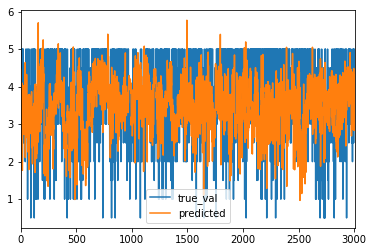

In [0]:
pd.DataFrame(zip(true_val ,validation_val), columns=['true_val', 'predicted']).plot()

## Seeing your own recommendations!

Movie list:

In [0]:
bestmovies = pd.DataFrame(index = movies.movie_id.index)
bestmovies['number of ratings'] =  movielens.pivot_table(index = 'movie_id', values = 'rating', aggfunc='count')
bestmovies['mean of rating'] = round(movielens.pivot_table(index = 'movie_id', values = 'rating', aggfunc='mean'),2)
bestmovies['std of rating'] = round(movielens.pivot_table(index = 'movie_id', values = 'rating', aggfunc='std'), 2)
# bestmovies['movie name'] = movies.loc[movies.movie_id == bestmovies.index]['title']

bestmovies.sort_values(by = 'number of ratings',ascending=False)

# bestmovies.corr()

In [0]:
movieList = movies['title']
movieList['movie_id'] = movies['movie_id']
n_m = len(movieList)
pd.DataFrame(movieList).head(20)

,title
1,Toy Story (1995)
2,Jumanji (1995)
3,Grumpier Old Men (1995)
4,Waiting to Exhale (1995)
5,Father of the Bride Part II (1995)
6,Heat (1995)
7,Sabrina (1995)
8,Tom and Huck (1995)
9,Sudden Death (1995)
10,GoldenEye (1995)


In [0]:
#Adding our own ratings

n_m = pivot_train.values.shape[0]

#  Initialize my ratings
my_ratings = np.zeros(n_m)


# my_ratings[4993] = 5
my_ratings[1080] = 5
my_ratings[260] = 5
# my_ratings[4896] = 5
my_ratings[1196] = 5
my_ratings[1210] = 5
# my_ratings[2628] = 5
# my_ratings[5378] = 5




print('User ratings:')
print('-----------------')

for i, val in enumerate(my_ratings):
    if val > 0:
        print('Rated %d stars: %s' % (val, movies.loc[movies.movie_id==str(i)].title.values))

User ratings:
-----------------
Rated 5 stars: ['Star Wars: Episode IV - A New Hope (1977)']
Rated 5 stars: ["Monty Python's Life of Brian (1979)"]
Rated 5 stars: ['Star Wars: Episode V - The Empire Strikes Back (1980)']
Rated 5 stars: ['Star Wars: Episode VI - Return of the Jedi (1983)']


In [0]:
Y.shape, R.shape, X.shape, Theta.shape

((663, 327), (663, 327), (663, 5), (327, 5))

In [0]:
pivot_train

In [0]:
#  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies by 943 users

Y = pivot_train.values

R = Y > 0

print("Adding your recommendations!")
Y = np.hstack([my_ratings[:, None], Y])
R = np.hstack([(my_ratings > 0)[:, None], R])

#  Normalize Ratings
Ynorm, Ymean = normalizeRatings(Y, R)

#  Useful Values
num_movies, num_users = Y.shape

num_features = 30

# Set Initial Parameters (Theta, X)
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

initial_parameters = np.concatenate([X.ravel(), Theta.ravel()])

# Set options for scipy.optimize.minimize
options = {'maxiter': 50}

# Set Regularization
lambda_ = 20

#Optimizing using Gradient Descent (in scipy)
res = optimize.minimize(lambda x: cofiCostFunc(x, Ynorm, R, num_users,
                                               num_movies, num_features, lambda_),
                        initial_parameters,
                        method='L-BFGS-B',
                        jac=True,
                        options=options)
theta = res.x

# Unfold the returned theta back into U and W
X = theta[:num_movies*num_features].reshape(num_movies, num_features)
Theta = theta[num_movies*num_features:].reshape(num_users, num_features)

print('Recommender system learning completed.')


#Predictions:
p = np.dot(X, Theta.T)

#Adding back the mean of every movie, Ymean
predictions = p +  Ymean[:,np.newaxis]  #<< broadcasting, adding the Ymean vector to each column of p

train_predictions = pd.DataFrame(predictions)
columns = list(pivot_train.columns)
columns = [0] + columns

train_predictions.columns = columns

print(predictions.shape)



true_val = []
validation_val = []

tmp = list(np.setdiff1d(pivot_test.index, train_predictions.index))
for i in pivot_test.index:
    for j in pivot_test.columns:
        if (pivot_test.loc[i,j]!=0) and (i not in tmp):
#             print('i = {},j = {}'.format(i,j))
            validation_val.append(train_predictions.loc[i,j])
            true_val.append(pivot_test.loc[i,j])

true_val = np.array(true_val)
validation_val = np.array(validation_val)
RMSE = np.round(np.sqrt(np.square(true_val - validation_val).mean()),4)
MAE = np.round(np.abs(true_val - validation_val).mean(),4)

print('RMSE: {}, MAE: {}'.format(RMSE, MAE))
my_predictions = predictions[:,0]


Adding your recommendations!
Recommender system learning completed.
(1605, 775)
RMSE: 1.1473, MAE: 0.9199


In [0]:
Y[:,0][np.where(Y[:,0]>0)]

array([5., 5., 5., 5., 5., 5., 5., 5.])

In [0]:
ix = np.argsort(my_predictions)[::-1]

print('Top recommendations for you:')
print('----------------------------')
for i in range(50):
    j = ix[i]
    print('Predicting rating %.3f - %s' % (my_predictions[j], movieList[j]))

print('User ratings:')
print('-----------------')

for i, val in enumerate(my_ratings):
    if val > 0:
        print('Rated %d stars: %s' % (val, movies.loc[movies.movie_id==str(i)].title.values))

Top recommendations for you:
----------------------------
Predicting rating 4.483 - Meet Me in St. Louis (1944)
Predicting rating 4.462 - Congo (1995)
Predicting rating 4.461 - Emma (1996)
Predicting rating 4.452 - Clear and Present Danger (1994)
Predicting rating 4.439 - What's Eating Gilbert Grape (1993)
Predicting rating 4.414 - Thousand Acres, A (1997)
Predicting rating 4.383 - House of the Spirits, The (1993)
Predicting rating 4.376 - Hard Target (1993)
Predicting rating 4.371 - Perfect World, A (1993)
Predicting rating 4.364 - Firm, The (1993)
Predicting rating 4.355 - Scout, The (1994)
Predicting rating 4.351 - Kansas City (1996)
Predicting rating 4.340 - In the Name of the Father (1993)
Predicting rating 4.336 - Shining, The (1980)
Predicting rating 4.327 - Dangerous Minds (1995)
Predicting rating 4.322 - Cheech and Chong's Up in Smoke (1978)
Predicting rating 4.318 - Naked (1993)
Predicting rating 4.317 - Swing Kids (1993)
Predicting rating 4.316 - Star Trek: Generations (1994

In [0]:
#Test Predictions

N_min = min num of ratings per user
M_min = min number of ratings per movie

create new matrix based on N_min and M_min

TrainSet = for each instance reduce %of|constant from sample (e.g. leave out 5 randim ratings to test predictions)
TestSet = predictions left out

make prediction on TrainSet
calculate RMSE for each user
total score = mean of RMSE ?

which movies got the lowest RMSE?
check number of ratings per movie * RMSE

create the UltimateList - 10-15 movie list that can be splited ot Train-Test and will preform 

In [0]:
ratings.iloc[:,:3]

,user_id,movie_id,rating
0,195,241,3.000
1,185,301,3.000
2,21,376,1.000
3,243,50,2.000
4,165,345,1.000
...,...,...,...
99995,879,475,3.000
99996,715,203,5.000
99997,275,1089,1.000
99998,12,224,2.000


In [0]:
from scipy.sparse import csr_matrix

# pivot ratings into movie features
df_movie_features = ratings.iloc[:,:3].pivot(
    index='movie_id',
    columns='user_id',
    values='rating'
).fillna(0)
# convert dataframe of movie features to scipy sparse matrix
mat_movie_features = csr_matrix(df_movie_features.values)

# FastAI Embeddings model

In [0]:
# !pip install fastai
import pandas as pd
from fastai.collab import CollabDataBunch, collab_learner, EmbeddingNN


In [0]:
data = CollabDataBunch.from_df(ratings, valid_pct=0.15)
data.show_batch()



## EmbeddingDotBias Model

In [0]:
learn = collab_learner(data, n_factors=50, y_range=(0.,5.), wd=.1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


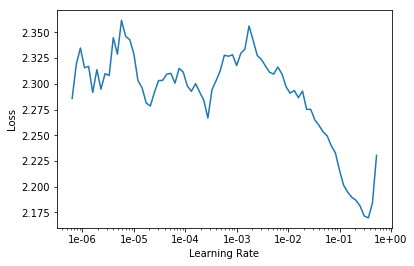

In [0]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.963994,0.956801,00:08
1,0.868230,0.883104,00:08
2,0.793230,0.830477,00:08
3,0.669829,0.811959,00:09
4,0.576130,0.809654,00:08


In [0]:
(users, items), ratings = next(iter(data.valid_dl))
preds = learn.model(users, items)
print('Real\tPred\tDifference')
for p in list(zip(ratings, preds))[:16]:
    print('{}\t{:.1f}\t{:.1f}'.format(p[0],p[1],p[1]-p[0]))


Real	Pred	Difference
3.0	2.2	-0.8
4.0	2.9	-1.1
2.0	2.8	0.8
3.0	2.9	-0.1
5.0	4.3	-0.7
3.0	3.7	0.7
1.0	2.4	1.4
5.0	4.3	-0.7
4.0	3.4	-0.6
1.0	2.9	1.9
4.0	4.2	0.2
5.0	4.3	-0.7
5.0	3.7	-1.3
2.0	2.9	0.9
2.0	3.1	1.1
2.0	3.7	1.7


##EmbeddingNN  Model

In [0]:
learn = collab_learner(data, use_nn=True, emb_szs={'user_id': 40, 'movie_id':40}, layers=[256, 128], y_range=(1, 5))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


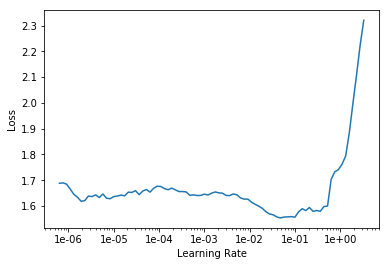

In [0]:
learn.lr_find() # find learning rate
learn.recorder.plot() # plot learning rate graph


In [0]:
learn.fit_one_cycle(5, 1e-2)


epoch,train_loss,valid_loss,time
0,0.996246,0.963006,00:11
1,0.914653,0.900042,00:11
2,0.883064,0.878848,00:11
3,0.818831,0.861804,00:11
4,0.784336,0.864615,00:11


In [0]:
learn.save('movies-dot-1')


# Recommendation using Keras Embeddings

We used a NN based Matrix Factorization method, where the matrices are embeddings learned my the model.
The final layer is a dot product as usual in MF.



In [0]:
# Load each data set (users, movies, and ratings).
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

train_df = pd.read_csv(
    'ml-100k/u1.base', sep='\t', names=ratings_cols, encoding='latin-1')

test_df = pd.read_csv(
    'ml-100k/u1.test', sep='\t', names=ratings_cols, encoding='latin-1')

In [0]:
pivot_train = train_df.pivot_table(values = 'rating', index = 'movie_id', columns = 'user_id')
pivot_train.fillna(0, inplace = True)

pivot_test = test_df.pivot_table(values = 'rating', index = 'movie_id', columns = 'user_id')
pivot_test.fillna(0, inplace = True)

In [0]:
# https://nipunbatra.github.io/blog/2017/recommend-keras.html

In [0]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(train_df[['user_id','movie_id','rating']], test_size=0.2)

In [0]:
train.shape, test.shape

((64000, 3), (16000, 3))

In [0]:
#Matrix factorisation in Keras
import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
n_users, n_movies = len(movielens.user_id.unique()), len(movielens.movie_id.unique())
from keras.regularizers import l2, l1

n_latent_factors = 30

Using TensorFlow backend.


**Dot architecture - Multi layer Embeddings**

Dedi - I added L1 regularization, because we were overfitting pretty hard.
L1 instead of L2, because L2 tends to make weights go to 0, and we will use the meaning of the embedding that way.

In [0]:
movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding', 
                                         embeddings_regularizer=l1(1e-6))(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1,
                                                                            n_latent_factors,name='User-Embedding',
                                                                           embeddings_regularizer=l1(1e-6))(user_input))

prod = keras.layers.dot([movie_vec, user_vec], axes=1, normalize=False) #original command from article: prod = keras.layers.merge([movie_vec, user_vec], mode='dot',name='DotProduct')
model = keras.Model([user_input, movie_input], prod)
model.compile(keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001, amsgrad=False), 'mae', metrics=['mse'])

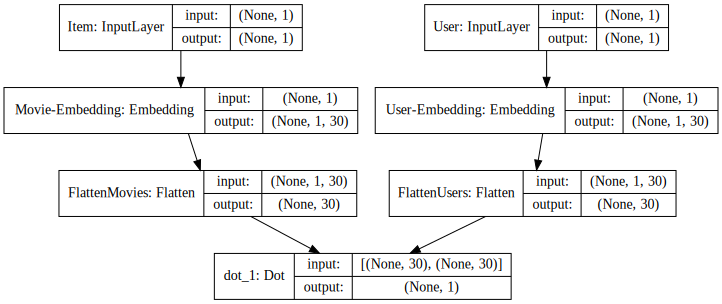

In [0]:
#model visualization
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [0]:
    model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 30)        50490       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 30)        28320       User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

 **TODO** 


1.   Add CV instead of test-train split
2.   Try different hyperparameters



In [0]:
history = model.fit([train.user_id, train.movie_id], train.rating, epochs=80, batch_size = 128,
                    validation_split=0.2, verbose=1)

Train on 51200 samples, validate on 12800 samples
Epoch 1/80
51200/51200 [==============================] - 2s 31us/step - loss: 3.4865 - mean_squared_error: 13.3849 - val_loss: 3.2157 - val_mean_squared_error: 11.5401
Epoch 2/80
51200/51200 [==============================] - 1s 26us/step - loss: 2.1190 - mean_squared_error: 6.0186 - val_loss: 1.2726 - val_mean_squared_error: 2.4976
Epoch 3/80
51200/51200 [==============================] - 1s 26us/step - loss: 1.0456 - mean_squared_error: 1.7498 - val_loss: 0.9500 - val_mean_squared_error: 1.4418
Epoch 4/80
51200/51200 [==============================] - 1s 26us/step - loss: 0.8648 - mean_squared_error: 1.2080 - val_loss: 0.8637 - val_mean_squared_error: 1.1889
Epoch 5/80
51200/51200 [==============================] - 1s 26us/step - loss: 0.8056 - mean_squared_error: 1.0466 - val_loss: 0.8262 - val_mean_squared_error: 1.0878
Epoch 6/80
51200/51200 [==============================] - 1s 26us/step - loss: 0.7784 - mean_squared_error: 0.976

KeyboardInterrupt: ignored

**With Regularization:**

In [0]:
#train loss vs. epochs 
pd.Series(history.history['loss']).plot(logy=True, label = "Train Loss")
pd.Series(history.history['val_loss']).plot(logy=True, color='green', label = "Val Loss")

plt.title("Train Loss vs Val Loss - with L1 regularization")
plt.xlabel("Epoch")
plt.ylabel("Loss (Log)")
plt.legend()

y_hat = np.round(model.predict([test.user_id, test.movie_id]),0)
y_true = test.rating

from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)


**Without Regularization:**

This is a clear overfit :)


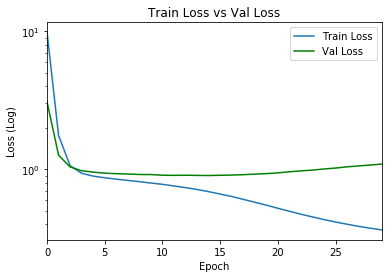

In [0]:
#train loss vs. epochs 
pd.Series(history.history['loss']).plot(logy=True, label = "Train Loss")
pd.Series(history.history['val_loss']).plot(logy=True, color='green', label = "Val Loss")

plt.title("Train Loss vs Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (Log)")
plt.legend()

print("This is a clear overfit :) \n")

In [0]:
y_hat = np.round(model.predict([test.user_id, test.movie_id]),0)
y_true = test.rating

from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)


0.7715

**Embeddings->NN Architecture**

In [0]:
n_latent_factors_user = 5
n_latent_factors_movie = 8

movie_input = keras.layers.Input(shape=[1],name='Movie')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
movie_vec = keras.layers.Dropout(0.012)(movie_vec)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,
                                                                            name='User-Embedding')(user_input))
user_vec = keras.layers.Dropout(0.02)(user_vec)


concat = keras.layers.concatenate([movie_vec, user_vec], axis= 1, name='Concat')


concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(200,name='FullyConnected')(concat)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1')(concat)
dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dense_2)
dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)


result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
adam = Adam()
model = keras.Model([user_input, movie_input], result)
model.compile(optimizer=adam,loss= 'mean_squared_error')

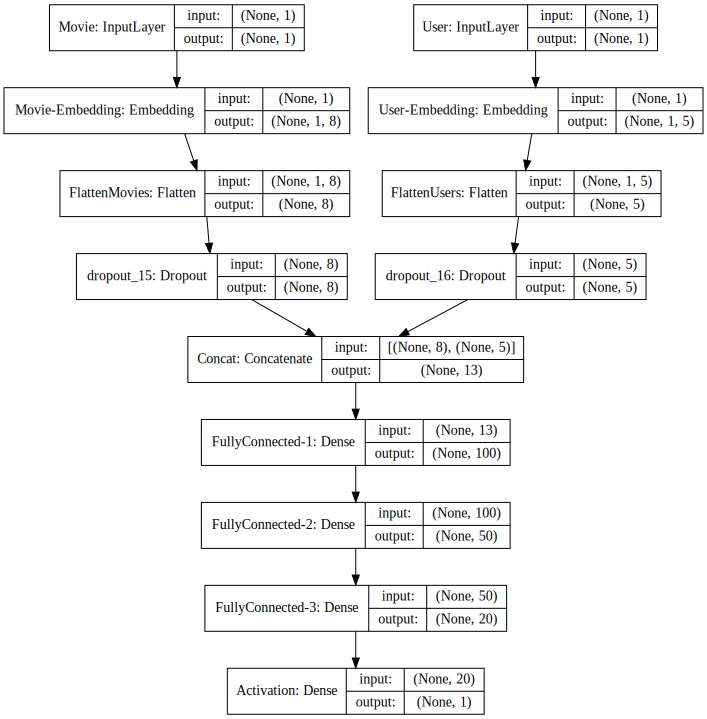

In [0]:
#model visualization
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [0]:
history = model.fit([train.user_id, train.movie_id], train.rating, epochs=50, 
                    validation_split=0.2, verbose=1)

Train on 64000 samples, validate on 16000 samples
Epoch 1/50
64000/64000 [==============================] - 10s 152us/step - loss: 1.1961 - val_loss: 0.9325
Epoch 2/50
64000/64000 [==============================] - 9s 133us/step - loss: 0.8980 - val_loss: 0.9178
Epoch 3/50
64000/64000 [==============================] - 9s 133us/step - loss: 0.8873 - val_loss: 0.9195
Epoch 4/50
64000/64000 [==============================] - 8s 133us/step - loss: 0.8769 - val_loss: 0.9051
Epoch 5/50
64000/64000 [==============================] - 9s 133us/step - loss: 0.8739 - val_loss: 0.9064
Epoch 6/50
64000/64000 [==============================] - 9s 134us/step - loss: 0.8700 - val_loss: 0.9048
Epoch 7/50
64000/64000 [==============================] - 9s 134us/step - loss: 0.8658 - val_loss: 0.9081
Epoch 8/50
64000/64000 [==============================] - 8s 133us/step - loss: 0.8572 - val_loss: 0.8882
Epoch 9/50
64000/64000 [==============================] - 9s 134us/step - loss: 0.8413 - val_loss: 0.

0.7235

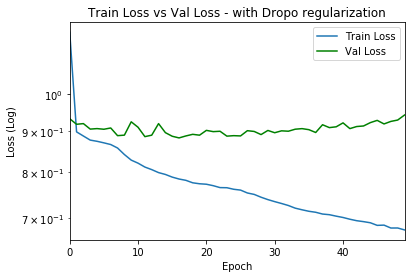

In [0]:
#train loss vs. epochs 
pd.Series(history.history['loss']).plot(logy=True, label = "Train Loss")
pd.Series(history.history['val_loss']).plot(logy=True, color='green', label = "Val Loss")

plt.title("Train Loss vs Val Loss - with Dropo regularization")
plt.xlabel("Epoch")
plt.ylabel("Loss (Log)")
plt.legend()

y_hat = np.round(model.predict([test.user_id, test.movie_id]),0)
y_true = test.rating

from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)


In [0]:
#Matedata Exploration

# users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
userinfo = pd.read_csv(
    'ml-100k/u.info', sep='', names=users_cols, encoding='latin-1')
userinfo


,user_id,age,sex,occupation,zip_code
0,943 users,NaN,NaN,NaN,NaN
1,1682 items,NaN,NaN,NaN,NaN
2,100000 ratings,NaN,NaN,NaN,NaN


In [0]:
# Reading ratings file
ratings = pd.read_csv('ratings.csv', sep='\t', encoding='latin-1', 
                      usecols=['user_id', 'movie_id', 'user_emb_id', 'movie_emb_id', 'rating'])
max_userid = ratings['user_id'].drop_duplicates().max()
max_movieid = ratings['movie_id'].drop_duplicates().max()

# Reading ratings file
users = pd.read_csv('users.csv', sep='\t', encoding='latin-1', 
                    usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

# Reading ratings file
movies = pd.read_csv('movies.csv', sep='\t', encoding='latin-1', 
                     usecols=['movie_id', 'title', 'genres'])


FileNotFoundError: ignored

In [0]:
.# Create training set
shuffled_ratings = ratings.sample(frac=1., random_state=42)

# Shuffling users
Users = shuffled_ratings['user_emb_id'].values
print ('Users:', Users, ', shape =', Users.shape)

# Shuffling movies
Movies = shuffled_ratings['movie_emb_id'].values
print ('Movies:', Movies, ', shape =', Movies.shape)

# Shuffling ratings
Ratings = shuffled_ratings['rating'].values
print ('Ratings:', Ratings, ', shape =', Ratings.shape)


KeyError: ignored

# Matrix Factorization via Singular Value Decomposition

Based on great work done by **Nick Becker**, RAPIDS Team at NVIDIA

*   https://beckernick.github.io/matrix-factorization-recommender/
*   https://github.com/beckernick/matrix_factorization_recommenders

This gave us great recommendations, however the RMSE we got was pretty high (probably due to some normalization factor we didn't account for)


Matrix factorization is the breaking down of one matrix in a product of multiple matrices. It's extremely well studied in mathematics, and it's highly useful. There are many different ways to factor matrices, but singular value decomposition is particularly useful for making recommendations.

So what is singular value decomposition (SVD)? At a high level, SVD is an algorithm that decomposes a matrix $R$ into the best lower rank (i.e. smaller/simpler) approximation of the original matrix $R$. Mathematically, it decomposes R into a two unitary matrices and a diagonal matrix:

$$\begin{equation}
R = U\Sigma V^{T}
\end{equation}$$

where R is users's ratings matrix, $U$ is the user "features" matrix, $\Sigma$ is the diagonal matrix of singular values (essentially weights), and $V^{T}$ is the movie "features" matrix. $U$ and $V^{T}$ are orthogonal, and represent different things. $U$ represents how much users "like" each feature and $V^{T}$ represents how relevant each feature is to each movie.

To get the lower rank approximation, we take these matrices and keep only the top $k$ features, which we think of as the underlying tastes and preferences vectors.


## Setting Up the Ratings Data

In [0]:
import pandas as pd
import numpy as np
import zipfile
import urllib.request

print("Downloading movielens data...")
    
urllib.request.urlretrieve("http://files.grouplens.org/datasets/movielens/ml-latest-small.zip", "movielens.zip")

zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()


ratings_df = pd.read_csv('ml-latest-small/ratings.csv', names=['user_id', 'movie_id', 'rating', 'timestamp'], sep=',', encoding='latin-1', header = None)
ratings_df.drop([0], inplace=True)
ratings_df=ratings_df.apply(pd.to_numeric)
# ratings_df['UserID'] = ratings_df['UserID'].apply(pd.to_numeric)
# ratings_df['UserID'] = ratings_df['UserID'].apply(pd.to_numeric)


movies_df = pd.read_csv('ml-latest-small/movies.csv',names= ['movie_id', 'title', 'genres'], sep=',', encoding='latin-1')
movies_df.drop([0], inplace=True)
movies_df['movie_id'] = movies_df['movie_id'].apply(pd.to_numeric)
# movies_df.drop('Genres', axis = 1, inplace = True)

# Create one merged DataFrame containing all the movielens data.
movielens18 = ratings_df.merge(movies_df, on='movie_id')

I'll also take a look at the movies and ratings dataframes.

In [0]:
movies_df.shape

(9742, 3)

In [0]:
movielens18.head()

,user_id,movie_id,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [0]:
R_df = ratings_df.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0)
R_df.head()

movie_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,185135,185435,185473,185585,186587,187031,187541,187593,187595,187717,188189,188301,188675,188751,188797,188833,189043,189111,189333,189381,189547,189713,190183,190207,190209,190213,190215,190219,190221,191005,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


de-mean the data (normalize by each users mean) and convert it from a dataframe to a numpy array.

In [0]:
R = R_df.as_matrix()

Z = R>0
m, n = R.shape
Ymean = np.zeros(m)
Ynorm = np.zeros(R.shape)

for i in range(m):
    idx = Z[i, :] == 1
    Ymean[i] = np.mean(R[i, idx])
    Ynorm[i, idx] = R[i, idx] - Ymean[i]    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [0]:
R_demeaned = R - Ymean[:,np.newaxis]

## Singular Value Decomposition

Scipy and Numpy both have functions to do the singular value decomposition. I'm going to use the Scipy function `svds` because it let's me choose how many latent factors I want to use to approximate the original ratings matrix (instead of having to truncate it after).

In [0]:
from scipy.sparse.linalg import svds
K = 10
U, sigma, Vt = svds(R_demeaned, k = 10)

In [0]:
df.head()

,movie_id,title,genres
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,2,Jumanji (1995),Adventure|Children|Fantasy
3,3,Grumpier Old Men (1995),Comedy|Romance
4,4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,5,Father of the Bride Part II (1995),Comedy


Done. The function returns exactly what I detailed earlier in this post, except that the $\Sigma$ returned is just the values instead of a diagonal matrix. This is useful, but since I'm going to leverage matrix multiplication to get predictions I'll convert it to the diagonal matrix form.

In [0]:
sigma = np.diag(sigma)

## Making Predictions from the Decomposed Matrices

In [0]:
pd.DataFrame(np.dot(np.dot(U, sigma), Vt)).head() + Ymean[:,np.newaxis]

In [0]:
pd.DataFrame(np.dot(np.dot(U, sigma), Vt)).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9684,9685,9686,9687,9688,9689,9690,9691,9692,9693,9694,9695,9696,9697,9698,9699,9700,9701,9702,9703,9704,9705,9706,9707,9708,9709,9710,9711,9712,9713,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,2.731634,0.824226,0.863543,-0.128215,0.117660,1.620033,0.022565,-0.117652,0.050279,1.912932,0.552621,0.254022,0.005336,-0.102017,-0.180319,0.948455,0.061236,-0.096068,0.687209,0.151289,1.261252,0.181749,-0.017190,0.252383,0.495318,-0.188269,-0.199703,-0.273025,0.547097,-0.012557,-0.111906,2.252317,1.131754,0.199436,0.003295,0.714506,-0.106971,-0.008130,0.051073,-0.122895,...,-0.157027,-0.115065,-0.071877,-0.075409,-0.071877,-0.087704,-0.120529,-0.110677,-0.104763,-0.090134,-0.092262,-0.082204,-0.164606,-0.127641,-0.058698,-0.179804,-0.112345,-0.112530,-0.123898,-0.149409,-0.113312,-0.100775,-0.114916,-0.111973,-0.112902,-0.111787,-0.111973,-0.111787,-0.111787,-0.126525,-0.123168,-0.121489,-0.124847,-0.124847,-0.123168,-0.124847,-0.123168,-0.123168,-0.123168,-0.133069
1,0.178901,-0.038069,-0.037811,-0.006254,0.016541,0.076676,-0.073422,-0.002933,-0.018228,-0.082428,0.002699,-0.049389,-0.039679,-0.037711,-0.055149,0.211399,-0.075330,-0.094330,-0.072832,0.051227,-0.037693,-0.040162,-0.023834,-0.059590,0.045661,-0.070228,0.005690,-0.095775,-0.204458,-0.022554,0.016811,0.005587,-0.089603,0.000461,0.006093,-0.017727,-0.009136,-0.070792,-0.004064,-0.043874,...,0.031704,0.010337,0.000233,0.016881,0.000233,-0.002226,0.013059,0.091506,0.004994,0.000808,-0.000043,-0.044401,-0.005832,0.006365,0.002879,-0.005297,-0.004993,-0.004451,-0.001224,-0.006367,-0.008008,-0.003448,-0.004725,-0.006077,-0.003367,-0.006620,-0.006077,-0.006620,-0.006620,-0.000455,-0.002066,-0.002871,-0.001260,-0.001260,-0.002066,-0.001260,-0.002066,-0.002066,-0.002066,0.005347
2,0.023583,-0.001087,0.009023,-0.006277,-0.024101,0.065603,-0.024909,-0.005670,0.005685,0.055995,-0.022128,0.021467,0.000627,-0.007039,-0.006482,-0.006187,-0.038940,0.000050,0.002065,0.009784,0.016307,-0.008969,-0.002138,-0.000635,-0.007776,-0.011981,-0.015251,-0.016733,0.021421,0.003982,-0.023048,0.052589,-0.016008,-0.024877,0.003988,-0.047013,-0.001045,0.000345,0.006930,-0.005408,...,-0.001495,0.000430,-0.000285,0.000377,-0.000285,-0.000713,-0.002556,0.010296,0.008870,-0.000708,-0.000762,0.010046,-0.002890,-0.001361,0.000034,-0.003361,-0.001517,-0.001573,-0.000727,-0.002418,-0.000932,-0.000974,-0.001406,-0.001406,-0.001684,-0.001351,-0.001406,-0.001351,-0.001351,-0.001205,-0.001213,-0.001217,-0.001209,-0.001209,-0.001213,-0.001209,-0.001213,-0.001213,-0.001213,-0.003140
3,1.479939,0.196467,0.192636,-0.035120,0.104789,0.194374,0.267949,-0.133225,-0.115444,-0.010298,0.718759,-0.133585,-0.007747,0.036157,-0.009510,0.395341,1.088663,0.172450,0.192556,-0.160884,0.877455,-0.066031,-0.167028,0.099026,0.699756,0.005758,-0.080493,0.334972,0.899928,0.085349,-0.010672,1.062285,0.975442,0.721076,-0.077426,1.067818,-0.097435,0.034366,-0.016771,-0.036849,...,-0.128765,-0.109915,-0.073742,-0.075341,-0.073742,-0.077813,-0.088481,-0.180858,-0.180034,-0.044795,-0.049857,-0.138352,-0.064030,-0.088939,-0.066516,-0.055062,-0.096042,-0.096166,-0.099938,-0.072999,-0.098290,-0.070107,-0.075434,-0.095793,-0.096415,-0.095669,-0.095793,-0.095669,-0.095669,-0.096665,-0.096388,-0.096250,-0.096527,-0.096527,-0.096388,-0.096527,-0.096388,-0.096388,-0.096388,-0.105531
4,1.256434,0.974787,0.403596,0.106501,0.518697,0.736876,0.617943,0.101136,0.094213,1.135083,1.039142,-0.009352,0.057612,0.268524,0.224823,0.492558,0.722043,0.036372,0.588009,0.010699,1.037831,0.473947,0.152440,0.153748,0.740593,0.207954,0.100080,0.087360,0.101443,-0.024128,0.434146,1.249361,1.437849,0.846536,-0.031665,1.015884,-0.017989,0.179374,-0.014745,0.105071,...,-0.016617,-0.023214,-0.020868,-0.018384,-0.020868,-0.020560,-0.017447,-0.024693,-0.043651,-0.014485,-0.015134,-0.031037,-0.008812,-0.019438,-0.020831,-0.005335,-0.018894,-0.018477,-0.0217

In [0]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + preds_df

### Making Movie Recommendations

In [0]:
Ymean[:,np.newaxis].shape

(610, 1)

In [0]:
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = R_df.columns)
print(preds_df.shape)

(610, 9724)


In [0]:
def recommend_movies(predictions_df, userID, movies_df, original_ratings_df, num_recommendations=5):
    
    # Get and sort the user's predictions
    user_row_number = userID -1
    sorted_user_predictions = predictions_df.iloc[user_row_number].sort_values(ascending=False)

    # Get the user's data and merge in the movie information.
    user_data = original_ratings_df[original_ratings_df.user_id == userID]
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'movie_id', right_on = 'movie_id').
                     sort_values(['rating'], ascending=False))

    print ('User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
    print ('Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies_df[~movies_df['movie_id'].isin(user_full['movie_id'])]. #all the movies not in the user_full recommendations
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movie_id',
               right_on = 'movie_id').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

In [0]:
already_rated, predictions = recommend_movies(preds_df, 25, movies_df, ratings_df, 10)

User 25 has already rated 26 movies.
Recommending highest 10 predicted ratings movies not already rated.


In [0]:
already_rated.head(10)

,user_id,movie_id,rating,timestamp,title,genres
13,25,68157,5.0,1535470515,Inglourious Basterds (2009),Action|Drama|War
12,25,60069,5.0,1535470523,WALLÂ·E (2008),Adventure|Animation|Children|Romance|Sci-Fi
23,25,180095,5.0,1535470476,Wonder (2017),Drama
22,25,177593,5.0,1535470532,"Three Billboards Outside Ebbing, Missouri (2017)",Crime|Drama
19,25,122912,5.0,1535470461,Avengers: Infinity War - Part I (2018),Action|Adventure|Sci-Fi
18,25,116797,5.0,1535470507,The Imitation Game (2014),Drama|Thriller|War
17,25,91529,5.0,1535470498,"Dark Knight Rises, The (2012)",Action|Adventure|Crime|IMAX
16,25,79132,5.0,1535470428,Inception (2010),Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX
14,25,68954,5.0,1535470493,Up (2009),Adventure|Animation|Children|Drama
1,25,260,5.0,1535470429,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi


In [0]:
predictions

,movie_id,title,genres
275,318,"Shawshank Redemption, The (1994)",Crime|Drama
312,356,Forrest Gump (1994),Comedy|Drama|Romance|War
2220,2959,Fight Club (1999),Action|Crime|Drama|Thriller
895,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
907,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
507,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
656,858,"Godfather, The (1972)",Crime|Drama
255,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
3187,4306,Shrek (2001),Adventure|Animation|Children|Comedy|Fantasy|Ro...
8358,109487,Interstellar (2014),Sci-Fi|IMAX


###Train Test Split

In [0]:
movielens18.shape

(100836, 6)

In [0]:
train_df = movielens18.sample(frac=0.9, random_state=0)
test_df = movielens18.drop(train_df.index.tolist())
train_df.shape, test_df.shape

((90752, 6), (10084, 6))

In [0]:
from sklearn.metrics import mean_absolute_error

# df = fetch_ml20m_ratings()
# movielens18.drop(columns = ['title', 'genres'], inplace=True)
# movielens18.columns = df.columns

train = movielens18.sample(frac=0.8, random_state=7)
val = movielens18.drop(train.index.tolist()).sample(frac=0.5, random_state=8)
test = movielens18.drop(train.index.tolist()).drop(val.index.tolist())

svd = SVD(learning_rate=0.01, regularization=0.1, n_epochs=100,
          n_factors=80, min_rating=1, max_rating=5)

svd.fit(X=train, X_val=val, early_stopping=True, shuffle=False)

pred = svd.predict(test)
mae = mean_absolute_error(test["rating"], pred)


NameError: ignored

In [0]:
min_user_clicks = 10
filter_users = train_df['user_id'].value_counts() > min_user_clicks
filter_users = filter_users[filter_users].index.tolist()

min_item_clicks = 10
filter_items = train_df['movie_id'].value_counts() > min_item_clicks
filter_items = filter_items[filter_items].index.tolist()

train_filtered = train_df[(train_df['user_id'].isin(filter_users)) & train_df['movie_id'].isin(filter_items)]
print('The original data frame shape:\t{}'.format(train_df.shape))
print('The new data frame shape:\t{}'.format(train_filtered.shape))


In [0]:
#Check that all users appears in both Train & Test

train_users_idx = list(train_filtered.user_id.unique())
test_df_idx = list(test_df.user_id.unique())
iters = list(set(train_users_idx) & set(test_df_idx))


train_filtered = train_filtered[train_filtered.user_id.isin(iters)]
test_df = test_df[test_df.user_id.isin(iters)]

In [0]:
#Check that all movies in Test appears in Train

train_movies_inx = list(train_filtered.movie_id.unique())
test_movies_inx = list(test_df.movie_id.unique())
uniques_movies_test = list(np.setdiff1d(test_movies_inx, train_movies_inx))
flt_lst = list(np.setdiff1d(test_movies_inx, uniques_movies_test))


test_df = test_df[test_df['movie_id'].isin(flt_lst)]

In [0]:
train_users = list(train_filtered.user_id.unique())
test_users = list(test_df.user_id.unique())
counter=0
for user in test_users:
    if user not in train_users:
        counter =+ 1
print("Number of non overlaps in users = {}".format(counter))

train_movies = list(train_filtered.movie_id.unique())
test_movies = list(test_df.movie_id.unique())
counter=0
for movie in test_movies:
    if movie not in train_movies:
        counter =counter + 1

print("Number movies in test that are not in train = {}".format(counter))

In [0]:
pivot_train = train_filtered.pivot_table(values = 'rating', index = 'movie_id', columns = 'user_id')
pivot_train.fillna(0, inplace = True)

pivot_test = test_df.pivot_table(values = 'rating', index = 'movie_id', columns = 'user_id')
pivot_test.fillna(0, inplace = True)

In [0]:
pivot_train.shape, pivot_test.shape

In [0]:
pivot_train.head()

In [0]:
pivot_test.head(5)

In [0]:
print("Train set contains {} ratings".format(np.sum(np.sum(pivot_train>0))))
print("Test set contains {} ratings".format(np.sum(np.sum(pivot_test>0))))

In [0]:
#Checking if movies in the test set are included in the train set

s_test = set(pivot_test.columns)
s_train = set(pivot_train.columns)

inter = s_test.issubset(s_train)
inter, len(s_train), len(s_test)

### Training the algorithm on the train set

In [0]:
R_df = pivot_train.copy()
R_df.head()

user_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,26,27,28,29,31,32,33,34,35,36,37,38,39,40,41,42,...,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,610
movie_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,4.5,3.5,4.0,0.0,3.5,0.0,0.0,0.0,0.0,3.0,0.0,0.0,5.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,4.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,3.0,2.5,4.0,0.0,4.0,3.0,4.0,2.5,0.0,2.5,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.5,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.5,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,2.5,4.0,0.0,4.0,0.0,0.0,3.5,0.0,0.0,2.0,0.0
3,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,4.5,0.0,0.0,3.5,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,3.5,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,4.5,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0


In [0]:
R = R_df.as_matrix()

Z = R>0
m, n = R.shape
Ymean = np.zeros(m)
Ynorm = np.zeros(R.shape)

for i in range(m):
    idx = Z[i, :] == 1
    Ymean[i] = np.mean(R[i, idx])
    Ynorm[i, idx] = R[i, idx] - Ymean[i]    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [0]:
R_demeaned = R - Ymean[:,np.newaxis]

In [0]:
from scipy.sparse.linalg import svds

In [0]:
'''
The best way I've found to do this..
Looping over the test pivot and locating the corresponding cell in the train set,
by INDEX, where the test-pivot has a rating.
'''
def accuracy(pivot_test, preds_df, k):
    true_val = []
    prediction_val = []

    movie_intersect = list(np.setdiff1d(pivot_test.index, preds_df.index))
    user_intersect = list(np.setdiff1d(pivot_test.columns, preds_df.columns))

    for i in pivot_test.index: #movie_id
        for j in pivot_test.columns: #user_id
            if (pivot_test.loc[i,j]!=0) and (i not in movie_intersect):
                real_value = pivot_test.loc[i,j]
                prediction = preds_df.loc[i,j]
#                 print('movie_id = {},user_id = {}'.format(i,j))
#                 print("real value = {}, prediction = {}".format(real_value, prediction))
                prediction_val.append(preds_df.loc[i,j] + Ymean[:,np.newaxis])
                true_val.append(pivot_test.loc[i,j])

    true_val = np.array(true_val)
    validation_val = np.array(prediction_val)
    RMSE = np.round(np.sqrt(np.square(true_val - prediction_val).mean()),4)
    MAE = np.round(np.abs(true_val - prediction_val).mean(),4)

    print('RMSE: {}, MAE: {}, K: {}'.format(RMSE, MAE, k))
    return (RMSE, MAE)

In [0]:
results = pd.DataFrame(columns=['RMSE', 'MAE','K'])

In [0]:
pivot_train

In [0]:
preds_df.head()

user_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,26,27,28,29,31,32,33,34,35,36,37,38,39,40,41,42,...,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,610
1,3.451891,0.058611,0.007331,2.637868,1.099987,3.230932,2.198768,1.193644,0.458786,0.541504,1.229292,0.177793,0.473869,0.738335,1.672910,1.059495,1.665207,3.663445,3.391498,3.579316,2.991586,0.399030,0.528706,1.105328,0.417550,2.416811,0.737759,0.500821,2.068553,2.782120,1.729464,0.793354,0.362697,0.122071,0.626887,1.287499,2.118650,1.572042,-0.011347,1.154391,...,3.487177,-0.038712,1.532049,5.176255,0.576355,0.277724,0.045875,1.171996,0.056506,1.627237,2.119013,0.540326,0.587333,0.791465,1.663337,0.019029,2.753613,1.486589,0.874798,0.928583,3.031569,1.030969,1.573785,2.113194,2.120092,0.456212,3.905150,2.109267,0.163412,1.939983,2.508578,1.832005,2.196829,0.668947,1.430875,2.476204,-1.218595,1.408496,1.771635,1.495228
2,0.894914,-0.092731,-0.071086,-0.153370,0.607579,3.121587,0.844036,1.391994,-0.040986,0.064775,0.618743,0.037675,-0.331725,0.779259,0.774952,0.026932,0.314524,2.036401,2.183381,1.420304,1.639731,-0.117252,-0.253789,0.263450,0.381263,0.952063,0.144212,0.033835,0.410589,0.832148,0.306754,0.061445,0.333529,-0.116311,0.579957,1.402147,0.230994,1.575549,-0.115456,0.396768,...,1.311270,0.203133,0.310089,1.649999,0.720692,-0.225939,-0.149671,0.555731,-0.062473,0.610019,1.250978,0.258769,0.213432,0.328823,2.397240,-0.493491,1.055446,0.830552,0.747009,0.701016,2.812340,-0.184432,2.111701,0.304915,1.519398,-0.068936,1.571269,0.132260,-0.058371,2.277476,2.868166,0.359764,2.048927,-0.693193,1.512298,1.680663,0.940717,0.817510,2.109111,0.809867
3,0.835231,0.176799,0.135655,-0.103934,0.244541,2.452694,-0.046309,0.305062,0.118281,-0.349651,0.364915,0.166561,-0.138204,0.425359,-0.267285,-0.400672,-0.010952,0.602568,1.522893,0.051047,-0.466322,-0.073531,-0.250858,-0.004646,0.083104,0.355020,0.321876,0.010884,0.450327,1.284789,0.325924,-0.270504,0.249414,0.187452,0.237916,0.576842,-0.014429,0.662791,-0.148310,2.446762,...,0.280190,0.180126,0.344350,-0.196989,0.112100,0.036494,0.135883,0.440409,0.094003,-0.093739,0.278460,-0.085237,-0.240761,0.069985,0.562625,0.258966,0.128109,0.696193,0.370148,0.452293,0.896718,0.020287,0.741429,0.035030,0.439975,0.079905,-0.522108,0.628086,0.031336,2.302958,1.877882,-0.518013,1.039225,-0.445847,0.859887,0.517374,0.465730,0.291600,2.158124,-1.147367
4,-0.005933,0.141640,0.076914,0.209794,0.457974,2.790473,0.130251,0.405387,0.105704,0.138638,0.272641,0.223936,-0.114563,0.538392,-0.213365,-0.298493,0.024003,0.768882,0.185059,0.101214,0.353634,0.048443,0.105409,0.092231,0.171479,0.251265,0.184331,0.065643,0.679358,1.594514,0.368817,-0.269517,0.313365,0.017324,0.230821,0.685795,-0.081723,0.942186,0.075291,0.969324,...,0.160051,0.066241,0.259483,0.199997,0.164557,-0.005609,0.082995,0.126856,0.095371,-0.232842,-0.137198,-0.030546,0.034345,0.133730,0.810954,0.167301,0.465687,0.323077,0.467235,0.485481,0.639930,-0.129197,0.836729,0.168541,0.402371,0.096907,0.048056,0.007177,0.084540,1.284753,1.376774,-0.167675,1.334417,-0.529334,1.032968,0.651285,0.646068,-0.234083,0.370818,-0.210490
5,1.057611,-0.054667,0.036791,0.559091,0.602180,3.332881,1.133493,0.413266,0.024486,-0.378158,1.351953,-0.048798,-0.039464,0.733045,0.558456,0.239070,1.195875,3.026044,-0.143045,-1.669538,0.549019,-0.059388,1.428677,0.780960,0.134476,0.170390,3.511240,0.811889,1.423887,3.137265,1.258200,-0.118721,0.206144,-0.007862,0.141090,0.844985,0.805467,0.958085,0.449198,2.103651,...,1.851180,0.093355,1.299100,2.193886,-0.001891,-0.091884,-0.116470,1.492557,-0.071569,-0.429140,3.284227,-0.435802,-0.423406,-0.313958,0.543579,0.934421,0.854894,-0.280835,1.100163,0.832717,2.924837,0.034789,1.065256,0.661926,1.473646,0.182405,0.188328,1.601696,-0.144806,3.175701,-0.477687,-0.254032,2.508251,2.747775,1.319326,-0.241857,1.135724,0.941970,3.116881,2.827764


In [0]:
U, sigma, Vt = svds(R_demeaned, k = 50, maxiter= 500)
sigma = np.diag(sigma)
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + Ymean[:,np.newaxis]
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = R_df.columns)
preds_df.index +=1
# RMSE, MAE = accuracy(pivot_test, preds_df, K)


In [0]:
# flattened_preds = pd.DataFrame(preds_df.to_records())
preds_df['movies'] = preds_df.index
preds_melted = pd.melt(preds_df, id_vars=['movies'], value_vars=preds_df.columns[:595])

In [0]:
preds_melted.head()
preds_melted.columns = ['movie_id', 'user_id', 'rating_predicted']

In [0]:
test_df = pd.merge(test_df, preds_melted,  how='inner', left_on=['user_id','movie_id'], right_on = ['user_id','movie_id'],)


In [0]:
test_df.shape

(3717, 9)

In [0]:
sum(test_df.rating_predicted.isna())

0

In [0]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(test_df.rating, test_df.rating_predicted)

3.1374667166646915

In [0]:
for K in range(1,2):
    U, sigma, Vt = svds(R_demeaned, k = K, maxiter= 500)
    sigma = np.diag(sigma)
    all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + Ymean[:,np.newaxis]
    preds_df = pd.DataFrame(all_user_predicted_ratings, columns = R_df.columns)
    RMSE, MAE = accuracy(pivot_test, preds_df, K)
    results.append([RMSE, MAE, K])

**This is really tough! I don't get why we got such a bad rmse..**


# Funk SVD - Final Model

Based on Repo by **Geoffrey Bolmier**, Université Paul Sabatier.
His repo implements Simon Funk's SVD algorithm fast and effieciently.

https://github.com/gbolmier/funk-svd

We got amazing recommendations with this algorithm and this is the final one we picked.

### **We also brought the model to 35 real users with a survey, where we got their own recommendations and got some good feedback.**

## Download Data


https://github.com/gbolmier/funk-svd/blob/master/funk_svd/svd.py

In [1]:
!pip install git+https://github.com/gbolmier/funk-svd

  Cloning https://github.com/gbolmier/funk-svd to /tmp/pip-req-build-n3mik0ke
  Running command git clone -q https://github.com/gbolmier/funk-svd /tmp/pip-req-build-n3mik0ke
  Stored in directory: /tmp/pip-ephem-wheel-cache-0p_6suex/wheels/66/f1/cb/e8147525b73388cc0bd5588c915e731ab65aba9a968e3ba455
Successfully built funk-svd


In [2]:
from funk_svd.dataset import fetch_ml20m_ratings
from funk_svd import SVD

from sklearn.metrics import mean_absolute_error

#20m dataset
import pandas as pd
import numpy as np
import zipfile
import urllib.request

Dataset20m = True
Download_new_dataset = True

if Download_new_dataset:
    if Dataset20m:
        print("Downloading 20-m movielens data...")

        urllib.request.urlretrieve("http://files.grouplens.org/datasets/movielens/ml-20m.zip", "movielens20m.zip")

        zip_ref = zipfile.ZipFile('movielens20m.zip', "r")
        zip_ref.extractall()
        print("Downloaded the 20-m movielens!")

        movies_df = pd.read_csv('ml-20m/movies.csv',names= ['i_id', 'title', 'genres'], sep=',', encoding='latin-1')
        movies_df.drop([0], inplace=True)
        movies_df['i_id'] = movies_df['i_id'].apply(pd.to_numeric)

        # Create one merged DataFrame containing all the movielens data.

        df = fetch_ml20m_ratings()
        movielens18 = df.copy()

    else:
        print("Downloading 100K latest movielens data...")

        urllib.request.urlretrieve("http://files.grouplens.org/datasets/movielens/ml-latest-small.zip", "movielens.zip")

        zip_ref = zipfile.ZipFile('movielens.zip', "r")
        zip_ref.extractall()

        ratings_df = pd.read_csv('ml-latest-small/ratings.csv', names=['u_id', 'i_id', 'rating', 'timestamp'], sep=',', encoding='latin-1', header = None)
        ratings_df.drop([0], inplace=True)
        ratings_df=ratings_df.apply(pd.to_numeric)


        movies_df = pd.read_csv('ml-latest-small/movies.csv',names= ['i_id', 'title', 'genres'], sep=',', encoding='latin-1')
        movies_df.drop([0], inplace=True)
        movies_df['i_id'] = movies_df['i_id'].apply(pd.to_numeric)

        # Create one merged DataFrame containing all the movielens data.
        movielens18 = ratings_df.merge(movies_df, on='i_id')
        movielens18.drop(axis = 1, columns = ['title', 'genres', 'timestamp'], inplace = True)
        movielens18.columns = ['u_id', 'i_id', 'rating']

Downloaded the 20-m movielens!
Unzipping data...


## HyperParameter Search

### Random Search

Sampling Learning rate, lambda, and number of latent features\factors from a uniform distribution, about 100 times.
In each iteration, the parameters as well as the RMSE and MAE are being saved in the results dataframe.

In [0]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# movielens18.drop(columns = 'timestamp', inplace = True)


train = movielens18.sample(frac=0.8)
val = movielens18.drop(train.index.tolist()).sample(frac=0.5, random_state=8)
test = movielens18.drop(train.index.tolist()).drop(val.index.tolist())

iterations = 100

def sample_params():
    lr = np.random.uniform(low = 0.001, high = 0.1,  size = 1)[0]
    reg = np.random.uniform(low = 0.001, high = 0.1,  size = 1)[0]
#     factors = np.random.randint(low = 100, high = 500,  size = 1)[0]
    factors = 300
    return lr, reg, factors

In [0]:
results = []
for i in range(iterations):
    
    lr, reg, factors = sample_params()
    
    svd = SVD(learning_rate=lr, regularization=reg, n_epochs=5, n_factors=factors,
              min_rating=0.5, max_rating=5)
    
    svd.fit(X=train, X_val=val, early_stopping=True, shuffle=False)

    pred = svd.predict(test)
    mae = mean_absolute_error(test["rating"], pred)
    rmse = np.sqrt(mean_squared_error(test["rating"], pred))
    print("Test MAE:  {:.2f}".format(mae))
    print("Test RMSE: {:.2f}".format(rmse))
    print('{} factors, {} lr, {} reg'.format(factors, lr, reg))
    results.append([rmse, mae, lr, reg, factors])

Preprocessing data...

Epoch 1/5  | val_loss: 0.74 - val_rmse: 0.86 - val_mae: 0.66 - took 18.8 sec
Epoch 2/5  | val_loss: 0.71 - val_rmse: 0.85 - val_mae: 0.65 - took 17.2 sec
Epoch 3/5  | val_loss: 0.70 - val_rmse: 0.84 - val_mae: 0.64 - took 17.5 sec
Epoch 4/5  | val_loss: 0.69 - val_rmse: 0.83 - val_mae: 0.64 - took 17.7 sec
Epoch 5/5  | val_loss: 0.68 - val_rmse: 0.82 - val_mae: 0.63 - took 17.6 sec

Training took 1 min and 41 sec
Test MAE:  0.63
Test RMSE: 0.82
300 factors, 0.03726422643591702 lr, 0.07328935967245179 reg


In [0]:
results = pd.DataFrame(results)
results.columns = ['RMSE', 'MAE', 'learningRate', 'Lambda', 'NumOfFeatures']

print("Random search results:")
results.sort_values(by='RMSE').head()

Random search results:


,RMSE,MAE,learningRate,Lambda,NumOfFeatures
0,0.82485,0.632915,0.037264,0.073289,300


### Training the best model

In [0]:
lr, reg, factors = (0.007, 0.03, 90)

svd = SVD(learning_rate=lr, regularization=reg, n_epochs=200, n_factors=factors,
          min_rating=0.5, max_rating=5)

svd.fit(X=train, X_val=val, early_stopping=True, shuffle=False)

pred = svd.predict(test)
mae = mean_absolute_error(test["rating"], pred)
rmse = np.sqrt(mean_squared_error(test["rating"], pred))
print("Test MAE:  {:.2f}".format(mae))
print("Test RMSE: {:.2f}".format(rmse))
print('{} factors, {} lr, {} reg'.format(factors, lr, reg))

Preprocessing data...

Epoch 1/200  | val_loss: 0.77 - val_rmse: 0.87 - val_mae: 0.67 - took 6.9 sec
Epoch 2/200  | val_loss: 0.75 - val_rmse: 0.86 - val_mae: 0.67 - took 6.2 sec
Epoch 3/200  | val_loss: 0.73 - val_rmse: 0.85 - val_mae: 0.66 - took 6.2 sec
Epoch 4/200  | val_loss: 0.71 - val_rmse: 0.84 - val_mae: 0.65 - took 6.1 sec
Epoch 5/200  | val_loss: 0.70 - val_rmse: 0.83 - val_mae: 0.64 - took 6.1 sec
Epoch 6/200  | val_loss: 0.68 - val_rmse: 0.83 - val_mae: 0.63 - took 6.1 sec
Epoch 7/200  | val_loss: 0.67 - val_rmse: 0.82 - val_mae: 0.63 - took 6.1 sec
Epoch 8/200  | val_loss: 0.66 - val_rmse: 0.81 - val_mae: 0.62 - took 6.1 sec
Epoch 9/200  | val_loss: 0.65 - val_rmse: 0.81 - val_mae: 0.62 - took 6.1 sec
Epoch 10/200 | val_loss: 0.64 - val_rmse: 0.80 - val_mae: 0.61 - took 6.1 sec
Epoch 11/200 | val_loss: 0.64 - val_rmse: 0.80 - val_mae: 0.61 - took 6.1 sec
Epoch 12/200 | val_loss: 0.63 - val_rmse: 0.80 - val_mae: 0.61 - took 6.1 sec
Epoch 13/200 | val_loss: 0.63 - val_rmse:

## User Recommendations

### Random Search

In [0]:
#Adding our own ratings

n_m = len(movielens18.i_id.unique())

#  Initialize my ratings
my_ratings = np.zeros(n_m)


my_ratings[4993] = 5
my_ratings[1080] = 5
my_ratings[260] = 5
my_ratings[4896] = 5
my_ratings[1196] = 5
my_ratings[1210] = 5
my_ratings[2628] = 5
my_ratings[5378] = 5

print('User ratings:')
print('-----------------')

for i, val in enumerate(my_ratings):
    if val > 0:
        print('Rated %d stars: %s' % (val, movies_df.loc[movies_df.i_id==i].title.values))

User ratings:
-----------------
Rated 5 stars: ['Star Wars: Episode IV - A New Hope (1977)']
Rated 5 stars: ["Monty Python's Life of Brian (1979)"]
Rated 5 stars: ['Star Wars: Episode V - The Empire Strikes Back (1980)']
Rated 5 stars: ['Star Wars: Episode VI - Return of the Jedi (1983)']
Rated 5 stars: ['Star Wars: Episode I - The Phantom Menace (1999)']
Rated 5 stars: ["Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)"]
Rated 5 stars: ['Lord of the Rings: The Fellowship of the Ring, The (2001)']
Rated 5 stars: ['Star Wars: Episode II - Attack of the Clones (2002)']


In [0]:
print("Adding your recommendations!")
items_id = [item[0] for item in np.argwhere(my_ratings>0)]
ratings_list = my_ratings[np.where(my_ratings>0)]
user_id = np.asarray([0] * len(ratings_list))

user_ratings = pd.DataFrame(list(zip(user_id, items_id, ratings_list)), columns=['u_id', 'i_id', 'rating'])

Adding your recommendations!


In [0]:
try:
    movielens18 = movielens18.drop(columns=['timestamp'])
except:
    pass
data_with_user = movielens18.append(user_ratings, ignore_index=True)

train_user = data_with_user.sample(frac=0.8)
val_user = data_with_user.drop(train_user.index.tolist()).sample(frac=0.5, random_state=8)
test_user = data_with_user.drop(train_user.index.tolist()).drop(val_user.index.tolist())

In [0]:
from itertools import product
def funk_svd_predict(userID, data_with_user, movies_df):
    userID = [userID]

    # all_users = data_with_user.u_id.unique()
    all_movies = data_with_user.i_id.unique()
    recommendations = pd.DataFrame(list(product(userID, all_movies)), columns=['u_id', 'i_id'])

    #Getting predictions for the selected userID
    pred_train = svd.predict(recommendations)
    recommendations['prediction'] = pred_train
    recommendations.head(10)

    sorted_user_predictions = recommendations.sort_values(by='prediction', ascending=False)

    user_ratings = data_with_user[data_with_user.u_id == userID[0]]
    user_ratings.columns = ['u_id',	'i_id', 'rating']
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = movies_df[~movies_df['i_id'].isin(user_ratings['i_id'])].\
        merge(pd.DataFrame(sorted_user_predictions).reset_index(drop=True), how = 'inner', left_on = 'i_id', right_on = 'i_id').\
        sort_values(by='prediction', ascending = False).drop(['i_id'],axis=1)

    rated_df = movies_df[movies_df['i_id'].isin(user_ratings['i_id'])].\
        merge(pd.DataFrame(data_with_user).reset_index(drop=True), how = 'inner', left_on = 'i_id', right_on = 'i_id')
    rated_df = rated_df.loc[rated_df.u_id==userID[0]].sort_values(by='rating', ascending = False)
    
    return recommendations, rated_df

In [0]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

iterations = 1

def sample_params():
    lr = np.random.uniform(low = 0.001, high = 0.01,  size = 1)[0]
    reg = np.random.uniform(low = 0.001, high = 0.1,  size = 1)[0]
    factors = np.random.randint(low = 30, high = 200,  size = 1)[0]
#     factors = 300
    return lr, reg, factors

In [0]:
#Checking Num Movies to see if this is the 20M data (should be 26K movies)
len(movielens18.i_id.unique())

26744

In [0]:
results = []
for i in range(iterations):
    
    lr, reg, factors = sample_params()
    
    svd = SVD(learning_rate=lr, regularization=reg, n_epochs=20, n_factors=factors,
              min_rating=0.5, max_rating=5)
    
    print('{} factors, {} lr, {} reg'.format(factors, lr, reg))

    svd.fit(X=train_user, X_val=val_user, early_stopping=True, shuffle=False)

    pred = svd.predict(test_user)
    mae = mean_absolute_error(test_user["rating"], pred)
    rmse = np.sqrt(mean_squared_error(test_user["rating"], pred))
    print("Test MAE:  {:.2f}".format(mae))
    print("Test RMSE: {:.2f}\n".format(rmse))
    results.append([rmse, mae, lr, reg, factors])

In [0]:
results = pd.DataFrame(results)
results.columns = ['RMSE', 'MAE', 'learningRate', 'Lambda', 'NumOfFeatures']

print("Random search results:")
results.sort_values(by='RMSE').head()

Random search results:


,RMSE,MAE,learningRate,Lambda,NumOfFeatures
0,0.833328,0.640036,0.00615,0.090192,30


### Training the best model

In [0]:
lr, reg, factors = (0.007, 0.03, 90)
epochs = 50

svd = SVD(learning_rate=lr, regularization=reg, n_epochs=epochs, n_factors=factors,
          min_rating=0.5, max_rating=5)

svd.fit(X=train_user, X_val=val_user, early_stopping=True, shuffle=False)

pred = svd.predict(test_user)
mae = mean_absolute_error(test_user["rating"], pred)
rmse = np.sqrt(mean_squared_error(test_user["rating"], pred))
print("Test MAE:  {:.2f}".format(mae))
print("Test RMSE: {:.2f}".format(rmse))
print('{} factors, {} lr, {} reg'.format(factors, lr, reg))

Preprocessing data...

Epoch 1/50  | val_loss: 0.76 - val_rmse: 0.87 - val_mae: 0.67 - took 6.1 sec
Epoch 2/50  | val_loss: 0.75 - val_rmse: 0.86 - val_mae: 0.66 - took 6.2 sec
Epoch 3/50  | val_loss: 0.73 - val_rmse: 0.85 - val_mae: 0.66 - took 6.2 sec
Epoch 4/50  | val_loss: 0.71 - val_rmse: 0.84 - val_mae: 0.65 - took 6.1 sec
Epoch 5/50  | val_loss: 0.69 - val_rmse: 0.83 - val_mae: 0.64 - took 6.1 sec
Epoch 6/50  | val_loss: 0.68 - val_rmse: 0.83 - val_mae: 0.63 - took 6.1 sec
Epoch 7/50  | val_loss: 0.67 - val_rmse: 0.82 - val_mae: 0.63 - took 6.1 sec
Epoch 8/50  | val_loss: 0.66 - val_rmse: 0.81 - val_mae: 0.62 - took 6.1 sec
Epoch 9/50  | val_loss: 0.65 - val_rmse: 0.81 - val_mae: 0.62 - took 6.1 sec
Epoch 10/50 | val_loss: 0.64 - val_rmse: 0.80 - val_mae: 0.61 - took 6.3 sec
Epoch 11/50 | val_loss: 0.64 - val_rmse: 0.80 - val_mae: 0.61 - took 6.3 sec
Epoch 12/50 | val_loss: 0.63 - val_rmse: 0.79 - val_mae: 0.61 - took 6.1 sec
Epoch 13/50 | val_loss: 0.63 - val_rmse: 0.79 - val_m

### Predictions:

In [0]:
from itertools import product
def funk_svd_predict(userID, data_with_user, movies_df):
    userID = [userID]

    # all_users = data_with_user.u_id.unique()
    all_movies = data_with_user.i_id.unique()
    recommendations = pd.DataFrame(list(product(userID, all_movies)), columns=['u_id', 'i_id'])

    #Getting predictions for the selected userID
    pred_train = svd.predict(recommendations)
    recommendations['prediction'] = pred_train
    recommendations.head(10)

    sorted_user_predictions = recommendations.sort_values(by='prediction', ascending=False)

    user_ratings = data_with_user[data_with_user.u_id == userID[0]]
    user_ratings.columns = ['u_id',	'i_id', 'rating']
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = movies_df[~movies_df['i_id'].isin(user_ratings['i_id'])].\
        merge(pd.DataFrame(sorted_user_predictions).reset_index(drop=True), how = 'inner', left_on = 'i_id', right_on = 'i_id').\
        sort_values(by='prediction', ascending = False)#.drop(['i_id'],axis=1)

    rated_df = movies_df[movies_df['i_id'].isin(user_ratings['i_id'])].\
        merge(pd.DataFrame(data_with_user).reset_index(drop=True), how = 'inner', left_on = 'i_id', right_on = 'i_id')
    rated_df = rated_df.loc[rated_df.u_id==userID[0]].sort_values(by='rating', ascending = False)
    
    return recommendations, rated_df

In [0]:
recommendations, rated_df = funk_svd_predict(0, data_with_user, movies_df)

In [0]:
rated_df

,i_id,title,genres,u_id,rating
54502,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,0,5.0
75060,1080,Monty Python's Life of Brian (1979),Comedy,0,5.0
120374,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,0,5.0
167214,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,0,5.0
196789,2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi,0,5.0
214029,4896,Harry Potter and the Sorcerer's Stone (a.k.a. ...,Adventure|Children|Fantasy,0,5.0
251583,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,0,5.0
268009,5378,Star Wars: Episode II - Attack of the Clones (...,Action|Adventure|Sci-Fi|IMAX,0,5.0


In [0]:
recommendations.head(30)

,i_id,title,genres,u_id,prediction
5845,5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy,0,5.000000
7348,7502,Band of Brothers (2001),Action|Drama|War,0,5.000000
7033,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy,0,5.000000
9784,31948,"Phone Box, The (Cabina, La) (1972)",Comedy|Drama|Mystery|Thriller,0,5.000000
2482,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0,5.000000
314,318,"Shawshank Redemption, The (1994)",Crime|Drama,0,4.981206
8965,26674,Prime Suspect (1991),Crime|Drama|Mystery|Thriller,0,4.968790
20463,100553,Frozen Planet (2011),Documentary,0,4.967922
49,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,0,4.956233
1111,1136,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy,0,4.938441


## Survey real users to showcase our model

**We created an online survey to aquire real user recommendations from Technion Data Science class and our friends.**

The survey is in Segmanta platform and can be accessed here:
https://surveys.segmanta.com/85fdg0

### Making A Survey

**We picked the top 20 movies from the 20-m Movielens data, that have the highest rating variation and also are popular.**

This was important, so that we get ratings that have high std in the data.


In [0]:
#setting up the list of movies for survey
number_of_ratings = pd.DataFrame(movielens18.groupby('i_id').count().loc[:,'rating'])
std_of_ratings = pd.DataFrame(movielens18.groupby('i_id').std().loc[:,'rating']) 
mean_of_ratings = pd.DataFrame(movielens18.groupby('i_id').mean().loc[:,'rating'])

x = number_of_ratings.merge(mean_of_ratings, how='inner', on = 'i_id').merge(std_of_ratings, how='inner', on = 'i_id')
x = x.merge(movies_df, how='inner', on = 'i_id')
x.drop('genres', axis = 1, inplace = True)
x.columns = ['MovieID', 'Number of Ratings', 'Avg Ratings', 'STD of ratings', 'Title']

In [0]:
movies_pick_std = x.sort_values(by = 'Number of Ratings', ascending = False).head(150).sort_values(by = 'STD of ratings', ascending = False).head(20)
movies_pick_mean = x.sort_values(by = 'Number of Ratings', ascending = False).head(150).sort_values(by = 'Avg Ratings', ascending = False).head(20)

frames = [movies_pick_std, movies_pick_mean]
picked_movies = pd.concat(frames)

picked_movies = picked_movies.sample(frac=1, random_state=0)

picked_movies = picked_movies.head(20)
picked_movies = picked_movies.reset_index(drop=True)
picked_movies.drop(['Number of Ratings', 'Avg Ratings', 'STD of ratings'], axis=1, inplace=True)

#picked_movies

**Adding new movies**

We decided to pick 24 more newer movies based on real-users survey.

the "new_survey_movies" csv contains the additional data.

In [119]:
#Adding new movies - upload the "new_survey_movies.csv" here

from google.colab import files
uploaded = files.upload()

Saving new_survey_movies.csv to new_survey_movies.csv


In [0]:
new_movies = pd.read_csv('new_survey_movies.csv', header=None)

In [0]:
for i, item in new_movies.iterrows():
    a = movies_df[movies_df.title==item[0]]
    line = pd.DataFrame({'MovieID':a.i_id.values[0], 'Title':a.title.values[0]}, index=[10])
    picked_movies = picked_movies.append(line, ignore_index=False)

picked_movies = picked_movies.reset_index(drop=True)
picked_movies.MovieID = picked_movies.MovieID.astype(int)

In [122]:
picked_movies

,MovieID,Title
0,50,"Usual Suspects, The (1995)"
1,318,"Shawshank Redemption, The (1994)"
2,912,Casablanca (1942)
3,2628,Star Wars: Episode I - The Phantom Menace (1999)
4,1517,Austin Powers: International Man of Mystery (1...
5,208,Waterworld (1995)
6,2959,Fight Club (1999)
7,780,Independence Day (a.k.a. ID4) (1996)
8,736,Twister (1996)
9,1198,Raiders of the Lost Ark (Indiana Jones and the...


### Adding Survey results to the data

In [123]:
#Loading Survey Data

from google.colab import files
uploaded = files.upload()

Saving movielens.xlsx to movielens.xlsx


In [125]:
num_of_survey_ratings = picked_movies.shape[0]

survey_data = pd.read_excel('movielens.xlsx')
survey_data.drop(axis=0, index = 0, inplace=True)
survey_data = survey_data.iloc[:, 12:].transpose()
Names = survey_data.iloc[num_of_survey_ratings-1]
survey_data.drop(survey_data.tail(4).index,inplace=True)
survey_data.reset_index(inplace=True)
survey_data.rename(columns={"index": "Title"}, inplace=True)
survey_data['MovieID'] =  None
survey_data.loc[:num_of_survey_ratings,'MovieID'] = picked_movies['MovieID']
survey_data.MovieID.astype(int)

##################################

survey_data = survey_data.merge(picked_movies, how='left', on='MovieID')   
# survey_data.Title = survey_data.Title.str.strip()
survey_data.drop(['Title_y'], axis=1, inplace = True)
survey_data.rename(columns={"Title_x": "Title"}, inplace=True)

survey_data= pd.melt(survey_data, id_vars=['MovieID', 'Title'], value_vars=list(range(1,38)),
                    var_name='UserID', value_name='rating')

#dropping NAN ratings (where there was no rating in the survey)

survey_data = survey_data[pd.notnull(survey_data['rating'])]
survey_data = survey_data.reset_index(drop=True)

survey_data.head(10)

,MovieID,Title,UserID,rating
0,318,The Shawshank Redemption (1994),1,5
1,912,Casablanca (1942),1,3
2,2628,Star Wars: Episode I - The Phantom Menace (1999),1,2
3,1517,Austin Powers: International Man of Mystery (1...,1,3
4,208,Waterworld (1995),1,2
5,2959,Fight Club (1999),1,5
6,780,Independence Day (a.k.a. ID4) (1996),1,3
7,736,Twister (1996),1,3
8,1198,Raiders of the Lost Ark (Indiana Jones) (1981),1,4
9,750,Dr. Strangelove (1964),1,5


In [0]:
user_ratings = survey_data[['UserID','MovieID','rating']]
user_ratings.columns = ['u_id', 'i_id', 'rating']

Creating the dataset with addition of the survey users


In [0]:
try:
    movielens18 = movielens18.drop(columns=['timestamp'])
except:
    pass

# shifting the u_id up, so the user_ids from the surveys will be 1,2,3 etc and the original u_id will start at 4, 5...
n_survey_users = len(Names)
# user_ratings.u_id += 1
movielens18.u_id += n_survey_users

data_with_user = user_ratings.append(movielens18, ignore_index=True).reset_index(drop=True)

train_user = data_with_user.sample(frac=0.9)
val_user = data_with_user.drop(train_user.index.tolist()).sample(frac=0.5, random_state=8)
test_user = data_with_user.drop(train_user.index.tolist()).drop(val_user.index.tolist())

In [0]:
data_with_user.groupby(by='u_id').count()[20:40]

In [0]:
#Crearing a popularity dataframe

movie_popularity = data_with_user.groupby(by='i_id').count()
movie_popularity['i_id'] = data_with_user.groupby(by='i_id').count().index
movie_popularity.drop(['u_id'], axis=1, inplace=True)
movie_popularity.rename(columns={"rating": "popularity"}, inplace=True)
movie_popularity = movie_popularity.reset_index(drop=True)

# merging movies_df with the popularity, by i_id

movies_df_with_popularity = movies_df.merge(movie_popularity, how = 'left', left_on = 'i_id', right_on = 'i_id').reset_index(drop=True)

### Train + Getting predictions

In [0]:
from itertools import product
from sklearn.metrics import mean_squared_error, mean_absolute_error
def funk_svd_predict(userID, data_with_user, movies_df):
    userID = [userID]

    # all_users = data_with_user.u_id.unique()
    all_movies = data_with_user.i_id.unique()
    recommendations = pd.DataFrame(list(product(userID, all_movies)), columns=['u_id', 'i_id'])

    #Getting predictions for the selected userID
    pred_train = svd.predict(recommendations)
    recommendations['prediction'] = pred_train
    recommendations.head(10)

    sorted_user_predictions = recommendations.sort_values(by='prediction', ascending=False)

    user_ratings = data_with_user[data_with_user.u_id == userID[0]]
    user_ratings.columns = ['u_id',	'i_id', 'rating']
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = movies_df[~movies_df['i_id'].isin(user_ratings['i_id'])].\
        merge(pd.DataFrame(sorted_user_predictions).reset_index(drop=True), how = 'inner', left_on = 'i_id', right_on = 'i_id').\
        sort_values(by='prediction', ascending = False).drop(['i_id'],axis=1)
    recommendations = recommendations.reset_index(drop=True)

    rated_df = movies_df[movies_df['i_id'].isin(user_ratings['i_id'])].\
        merge(pd.DataFrame(data_with_user).reset_index(drop=True), how = 'inner', left_on = 'i_id', right_on = 'i_id')
    rated_df = rated_df.loc[rated_df.u_id==userID[0]].sort_values(by='rating', ascending = False)
    rated_df = rated_df.reset_index(drop=True)
    return recommendations, rated_df

This are the best hyperparameters from our random search:

In [136]:
lr, reg, factors = (0.007, 0.03, 90)
epochs = 50

svd = SVD(learning_rate=lr, regularization=reg, n_epochs=epochs, n_factors=factors,
          min_rating=0.5, max_rating=5)

svd.fit(X=train_user, X_val=val_user, early_stopping=True, shuffle=False)

pred = svd.predict(test_user)
mae = mean_absolute_error(test_user["rating"], pred)
rmse = np.sqrt(mean_squared_error(test_user["rating"], pred))
print("Test MAE:  {:.2f}".format(mae))
print("Test RMSE: {:.2f}".format(rmse))
print('{} factors, {} lr, {} reg'.format(factors, lr, reg))

Preprocessing data...

Epoch 1/50  | val_loss: 0.76 - val_rmse: 0.87 - val_mae: 0.67 - took 8.0 sec
Epoch 2/50  | val_loss: 0.74 - val_rmse: 0.86 - val_mae: 0.66 - took 7.6 sec
Epoch 3/50  | val_loss: 0.72 - val_rmse: 0.85 - val_mae: 0.65 - took 7.4 sec
Epoch 4/50  | val_loss: 0.70 - val_rmse: 0.84 - val_mae: 0.64 - took 7.2 sec
Epoch 5/50  | val_loss: 0.69 - val_rmse: 0.83 - val_mae: 0.63 - took 7.4 sec
Epoch 6/50  | val_loss: 0.67 - val_rmse: 0.82 - val_mae: 0.63 - took 7.3 sec
Epoch 7/50  | val_loss: 0.66 - val_rmse: 0.81 - val_mae: 0.62 - took 7.4 sec
Epoch 8/50  | val_loss: 0.65 - val_rmse: 0.81 - val_mae: 0.62 - took 7.5 sec
Epoch 9/50  | val_loss: 0.64 - val_rmse: 0.80 - val_mae: 0.61 - took 7.6 sec
Epoch 10/50 | val_loss: 0.64 - val_rmse: 0.80 - val_mae: 0.61 - took 7.6 sec
Epoch 11/50 | val_loss: 0.63 - val_rmse: 0.79 - val_mae: 0.61 - took 7.5 sec
Epoch 12/50 | val_loss: 0.62 - val_rmse: 0.79 - val_mae: 0.60 - took 7.3 sec
Epoch 13/50 | val_loss: 0.62 - val_rmse: 0.79 - val_m

In [0]:
#Survey users:


### Getting recommendations

A nice trick we added is slicing the recommendations for popular movies only.
In the beggining, we got weird Soviet documentaries.. nobody wants to watch that.

We deduced that this is because some random user in the 20M dataset has very similar rating pattern to the survey user, therefore we got results that coresponds to its taste.

Decided to **recommend only popular movies (>100 ratings).** Reduced the variety and hurts discovery a bit,  but **improves results substantially**!

**This is also done by the big guys (Netflix, Amazon, Youtube)**


In [152]:
Selected_user = 36
print("predictions for {}".format(Names[Selected_user]))

recommendations, rated_df = funk_svd_predict(Selected_user, data_with_user, movies_df_with_popularity)

predictions for Dean Shabi


In [153]:
rated_df[['title', 'rating', 'genres']]

,title,rating,genres
0,Inception (2010),5,Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX
1,Iron Man (2008),5,Action|Adventure|Sci-Fi
2,"Lord of the Rings: The Return of the King, The...",5,Action|Adventure|Drama|Fantasy
3,Pirates of the Caribbean: The Curse of the Bla...,5,Action|Adventure|Comedy|Fantasy
4,Spider-Man (2002),5,Action|Adventure|Sci-Fi|Thriller
5,X-Men (2000),5,Action|Adventure|Sci-Fi
6,Scary Movie (2000),5,Comedy|Horror
7,"Lion King, The (1994)",5,Adventure|Animation|Children|Drama|Musical|IMAX
8,"Matrix, The (1999)",5,Action|Sci-Fi|Thriller
9,"Incredibles, The (2004)",5,Action|Adventure|Animation|Children|Comedy


In [154]:
recommendations[['title', 'prediction', 'genres', 'popularity']][recommendations.popularity>=100].head(40)

,title,prediction,genres,popularity
2,North & South (2004),4.843947,Drama|Romance,147.0
5,3 Idiots (2009),4.769312,Comedy|Drama|Romance,453.0
6,"Shawshank Redemption, The (1994)",4.767195,Crime|Drama,63395.0
7,"Sixth Sense, The (1999)",4.757356,Drama|Horror|Mystery,39028.0
8,Lifted (2006),4.748968,Animation|Comedy|Sci-Fi,127.0
10,Finding Nemo (2003),4.727982,Adventure|Animation|Children|Comedy,23569.0
11,Shrek (2001),4.717577,Adventure|Animation|Children|Comedy|Fantasy|Ro...,31972.0
13,Schindler's List (1993),4.709197,Drama|War,50054.0
14,Harry Potter and the Deathly Hallows: Part 2 (...,4.704267,Action|Adventure|Drama|Fantasy|Mystery|IMAX,3983.0
16,Eddie Izzard: Dress to Kill (1999),4.693521,Comedy,208.0


### Export to Excell

In [0]:
!pip install xlsxwriter
import xlsxwriter

writer = pd.ExcelWriter('predictions.xlsx', engine='xlsxwriter')

for i, user in enumerate(Names):
    print("recommendations for {}".format(Names[i+1]))
    recommendations, _ = funk_svd_predict(i+1, data_with_user, movies_df_with_popularity)
    sheetName = str(Names[i+1])+str(i)
    recommendations[['title', 'prediction', 'genres', 'popularity']][recommendations.popularity>=100].head(40).to_excel(writer, sheet_name=sheetName)
writer.save()

In [0]:
# !pip install xlsxwriter
import xlsxwriter

writer = pd.ExcelWriter('user_ratings.xlsx', engine='xlsxwriter')

for i, user in enumerate(Names):
    print("ratings for {}".format(Names[i+1]))
    _ , rated_df = funk_svd_predict(i+1, data_with_user, movies_df_with_popularity)
    sheetName = str(Names[i+1])+str(i)
    rated_df.to_excel(writer, sheet_name=sheetName)
writer.save()
